In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

# import importlib
# import utils
# importlib.reload(utils)

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp
import cv2
import scipy
from tqdm import tqdm

import skimage.io as io
import os

In [3]:
import pickle
import sys

In [57]:
sys.path.append('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/')

In [58]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py'>

# Read in data and trace particle positions

In [6]:
# read the image stack
foldername='/Volumes/maxone/20231012/new/new/0p5low_alg_12p5mM_3500ul_100um_20231013_120727_AM/'
imgname='0p5low_alg_12p5mM_3500ul_100um_20231013_120530_AM_20231013_120727_AM'
img_tif = io.imread(foldername+imgname+'.tif')

In [7]:
framerate=5647

In [19]:
scale_px=74/100 #px/um

In [9]:
ref=img_tif[558]

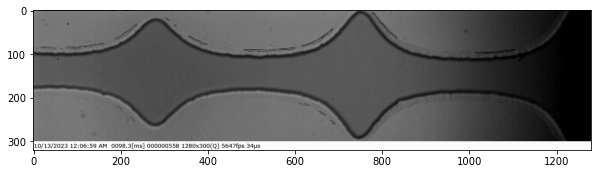

In [10]:
plt.imshow(ref)

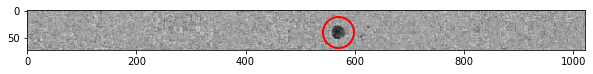

<AxesSubplot:>

In [11]:
crop_ys=107
crop_ye=179

crop_xs=18
crop_xe=1040

frame=626
size=31
target=img_tif[frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100
f_locate = tp.locate(target, size, minmass=1500, invert=True)
tp.annotate(f_locate, target, plot_style={'markersize': size})

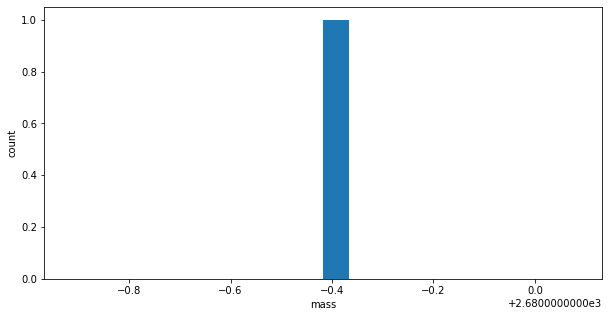

In [12]:
fig, ax = plt.subplots()
ax.hist(f_locate['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

In [13]:
start_frame=0
end_frame=7000


In [21]:
img_tif.shape

(7000, 320, 1280)

In [22]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    tp.batch(img_tif[start_frame:end_frame,crop_ys:crop_ye,crop_xs:crop_xe]-ref[crop_ys:crop_ye,crop_xs:crop_xe]+100,size, minmass=1500, invert=True, processes=1,output=s)

Frame 6999: 1 features


In [23]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    # As before, we require a minimum "life" of 5 frames and a memory of 3 frames
    for linked in tp.link_df_iter(s, 100, memory=0,link_strategy='hybrid'):
        s.put(linked)

Frame 6999: 1 trajectories present.


In [14]:
with tp.PandasHDFStore(imgname+'.h5') as s:
    t = pd.concat(iter(s))

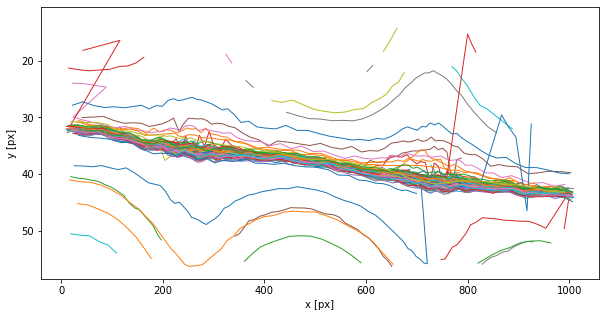

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [15]:
plt.figure()
tp.plot_traj(t)

In [16]:
t1 = tp.filter_stubs(t, 40)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 111
After: 73


In [17]:
t1_modified = t1.copy()
t1_modified['y'] = t1['y'] + crop_ys
t1_modified['x'] = t1['x'] + crop_xs
t1_modified['frame'] = t1['frame']+start_frame

In [18]:
t1_modified['particle'].unique()

array([  1,   2,   3,   5,   7,   9,  10,  11,  12,  14,  15,  16,  17,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  53,  56,  58,  59,  60,
        63,  64,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  80,  81,  82,  83,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 106, 108, 109, 110])

Text(0.5, 0, 's')

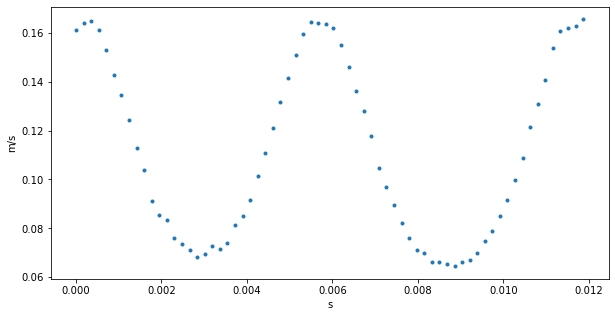

In [20]:
dt=1/framerate #s


x_pos=t1_modified[(t1_modified['particle'] == 1)]['x']
scale=10**(-6)/scale_px #um/px
v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

# Trace Particle Deformations

## velocity and stress field
for one single beads
- sanity check for edge detection and fitting algorithm
- this beads gives the velocity and rescales for the stress field

In [21]:
t1_modified[t1_modified['particle']==1]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,
54,139.019287,31.230657,2800.745539,8.556012,0.026514,9.606746,114239.0,NaN,54,1
55,138.868250,52.337753,2893.593723,8.361223,0.016152,9.068300,114725.0,NaN,55,1
56,140.183451,74.210940,2875.228496,8.352735,0.030755,8.765011,114546.0,NaN,56,1
57,139.202035,95.558389,2781.352679,8.096899,0.031080,9.706734,114674.0,NaN,57,1
58,140.259336,116.457652,2948.430937,8.390201,0.014282,8.675802,114885.0,NaN,58,1
...,...,...,...,...,...,...,...,...,...,...
117,149.780527,916.414066,2441.122380,8.280431,0.079337,8.547175,113753.0,NaN,117,1
118,150.498213,937.105863,2459.905941,8.404015,0.042184,7.920300,113879.0,NaN,118,1
119,149.805502,958.597070,2415.403833,8.495864,0.091139,7.680277,114045.0,NaN,119,1


In [41]:
yloc=139
xloc=31

roi=25
parts=img_tif[54][yloc-roi:yloc+roi,xloc-roi:xloc+roi]
blur_parts=cv2.GaussianBlur(parts,(7,7),3)

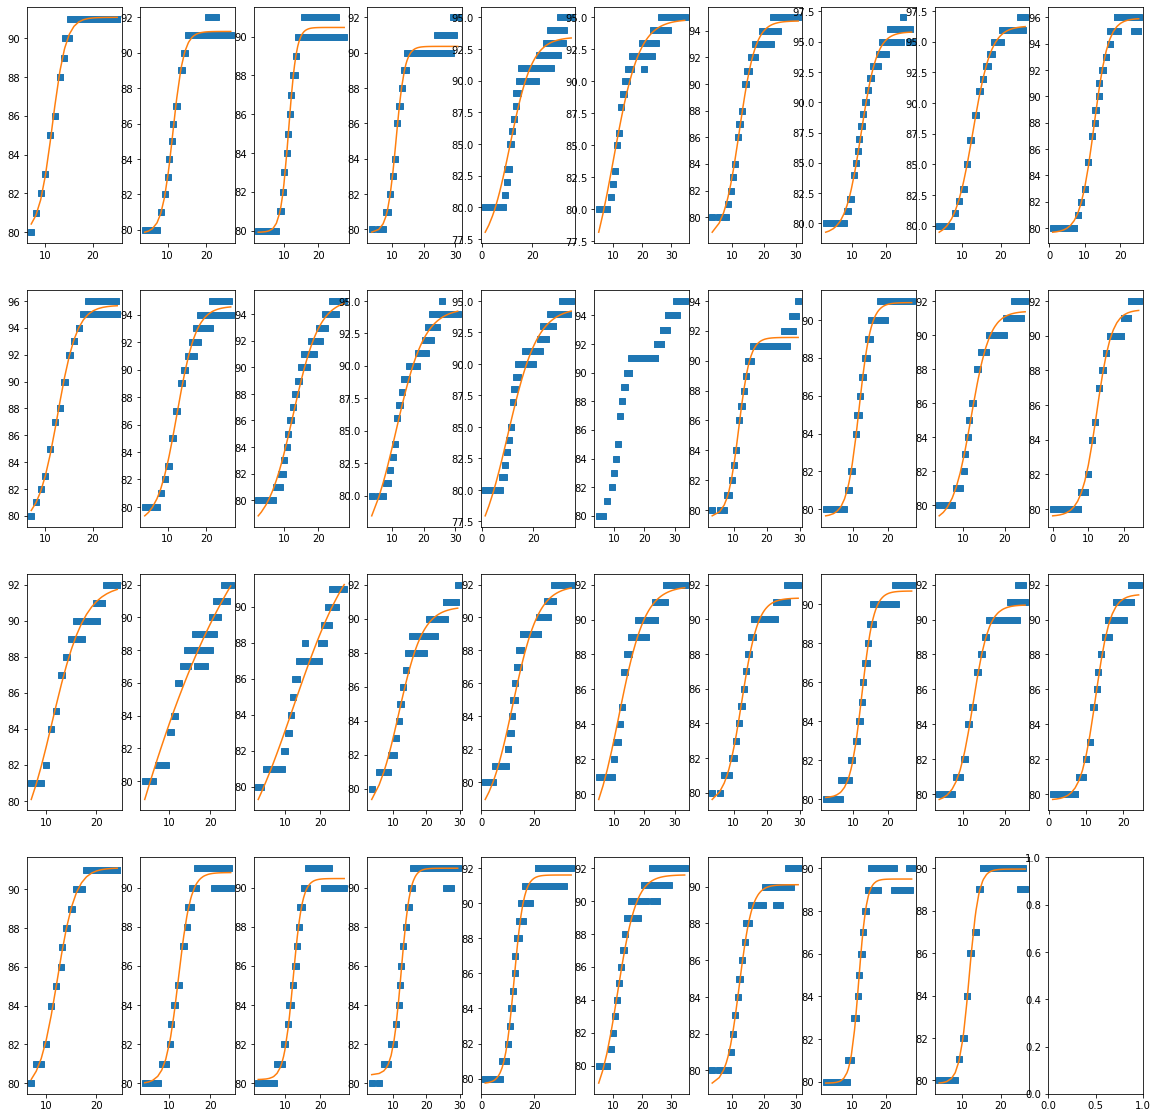

In [42]:
y_i, x_i=utils.detect_edge_sigmoid(blur_parts,roi,plot=True)

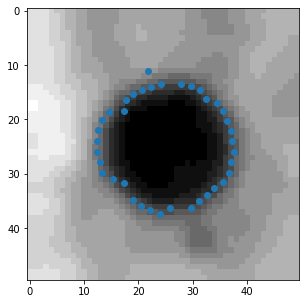

In [43]:
plt.imshow(blur_parts)
plt.plot(x_i,y_i,'o')

In [44]:
dire='/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/test/'
gamma_2 = utils.process_frames(img_tif,ref,t1_modified,1,dire)

frame number is54
frame number is55
frame number is56
frame number is57
frame number is58
frame number is59
frame number is60
frame number is61


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is62
frame number is63


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is64
frame number is65
frame number is66
frame number is67
frame number is68
frame number is69
frame number is70
frame number is71
frame number is72
frame number is73
frame number is74
frame number is75
frame number is76
frame number is77


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is78
frame number is79
frame number is80
frame number is81
frame number is82
frame number is83
frame number is84
frame number is85
frame number is86
frame number is87


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is88
frame number is89
frame number is90
frame number is91
frame number is92
frame number is93
frame number is94
frame number is95
frame number is96
frame number is97
frame number is98
frame number is99
frame number is100
frame number is101
frame number is102
frame number is103


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is104
frame number is105
frame number is106
frame number is107


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is108
frame number is109
frame number is110
frame number is111
frame number is112
frame number is113
frame number is114
frame number is115
frame number is116
frame number is117


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is118
frame number is119
frame number is120
frame number is121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


### velocity

Text(0.5, 0, 's')

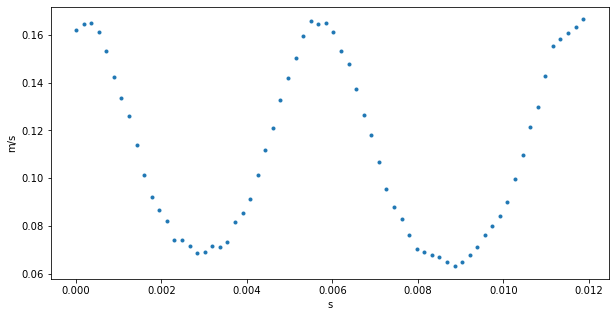

In [30]:
x_pos=t1_modified[(t1_modified['particle'] == 1)]['x']
v=np.gradient(x_pos,dt)*scale

# velocity in the middle of the channel
plt.plot(np.arange(0,len(x_pos))*dt,v,'.')
plt.ylabel('m/s')
plt.xlabel('s')

In [31]:
max_velocity=np.mean(sorted(v, reverse=True)[1:3])
print(max_velocity)

0.16529928109057745


### rescale for stress field

In [32]:
real_stress=utils.calculate_stress(max_velocity)
print('The real stess amplitude in this experiment is '+str(real_stress)+' Pa.')

Q is: 5792.086809413833 ul/h
The real stess amplitude in this experiment is 20.131091018531038 Pa.


### fit for G' and G''

521.781579847693
Storage modulus is:837.7207008575697
Loss modulus is:1367.4845484716707
R^2: 0.035552146866867806
[ 0.01255306  2.12042888 -0.01042352]


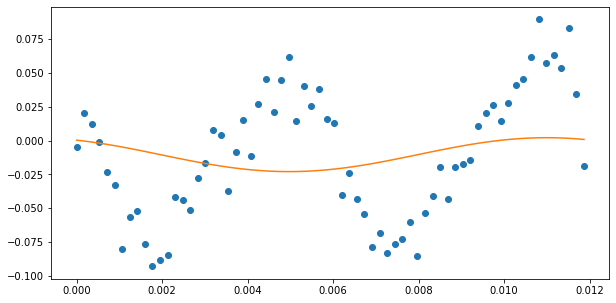

(837.7207008575697, 1367.4845484716707, 521.781579847693, 0.035552146866867806)

In [33]:
utils.calculate_modulus(framerate,gamma_2,real_stress)

# process all beads

## wavelength 1

In [59]:
wavelength1=t1_modified[(t1_modified['x'] >= 45) & (t1_modified['x'] <= 506)]

In [60]:
wavelength1['particle'].unique()

array([  1,   2,   3,   5,   7,   9,  10,  11,  12,  14,  15,  16,  17,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  53,  56,  58,  59,  60,
        63,  64,  66,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  80,  81,  82,  83,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 106, 108, 109, 110])

In [61]:
gamma2list_w1=utils.analyze_wavelength_gamma2(wavelength1,1,imgname,img_tif,ref)

particle number: 1
frame number is55
frame number is56
frame number is57
frame number is58
frame number is59
frame number is60
frame number is61


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is62
frame number is63


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is64
frame number is65
frame number is66
frame number is67
frame number is68
frame number is69
frame number is70
frame number is71
frame number is72
frame number is73
frame number is74
frame number is75
frame number is76
frame number is77


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is78
frame number is79
frame number is80
frame number is81
frame number is82
frame number is83
frame number is84
frame number is85
frame number is86
particle number: 2
frame number is173
frame number is174
frame number is175
frame number is176
frame number is177
frame number is178
frame number is179
frame number is180
frame number is181
frame number is182
frame number is183
frame number is184
frame number is185
frame number is186
frame number is187
frame number is188
frame number is189
frame number is190
frame number is191


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is192
frame number is193


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is194
frame number is195
frame number is196
frame number is197


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is198
frame number is199
frame number is200
frame number is201


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is202
frame number is203
frame number is204
particle number: 3
frame number is208


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is209
frame number is210
frame number is211
frame number is212
frame number is213
frame number is214
frame number is215
frame number is216
frame number is217
frame number is218
frame number is219
frame number is220
frame number is221
frame number is222


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is223
frame number is224


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is225
frame number is226
frame number is227
frame number is228
frame number is229
frame number is230


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is231
frame number is232
frame number is233
frame number is234


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is235
frame number is236
frame number is237
frame number is238
particle number: 5
frame number is296
frame number is297
frame number is298
frame number is299
frame number is300
frame number is301
frame number is302
frame number is303


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is304
frame number is305


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is306
frame number is307


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is308
frame number is309
frame number is310
frame number is311
frame number is312
frame number is313
frame number is314
frame number is315
frame number is316
frame number is317
frame number is318
frame number is319


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is320
frame number is321


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is322
frame number is323


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is324
frame number is325
frame number is326
frame number is327
particle number: 7
frame number is328
frame number is329
frame number is330
frame number is331
frame number is332
frame number is333
frame number is334
frame number is335
frame number is336
frame number is337
frame number is338
frame number is339


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is340
frame number is341


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is342
frame number is343
frame number is344
frame number is345
frame number is346
frame number is347
frame number is348
frame number is349
frame number is350
frame number is351
frame number is352
frame number is353


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is354
frame number is355
frame number is356
frame number is357
frame number is358
frame number is359
particle number: 9
frame number is591
frame number is592
frame number is593
frame number is594


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is595
frame number is596
frame number is597
frame number is598
frame number is599
frame number is600
frame number is601
frame number is602
frame number is603
frame number is604
frame number is605
frame number is606
frame number is607
frame number is608


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is609
frame number is610
frame number is611
frame number is612


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is613
frame number is614
frame number is615
frame number is616
frame number is617
frame number is618
frame number is619
frame number is620
frame number is621
frame number is622
particle number: 10
frame number is764
frame number is765


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is766
frame number is767
frame number is768
frame number is769


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is770
frame number is771
frame number is772
frame number is773


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is774
frame number is775
frame number is776
frame number is777
frame number is778
frame number is779
frame number is780
frame number is781


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is782
frame number is783


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is784
frame number is785


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is786
frame number is787


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is788
frame number is789


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is790
frame number is791
frame number is792


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is793
frame number is794


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is795
frame number is796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is797
frame number is798
frame number is799
frame number is800
particle number: 11
frame number is775
frame number is776
frame number is777
frame number is778
frame number is779
frame number is780
frame number is781
frame number is782
frame number is783
frame number is784
frame number is785
frame number is786


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is787
frame number is788
frame number is789
frame number is790


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is791
frame number is792
frame number is793
frame number is794


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is795
frame number is796
frame number is797
frame number is798


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is799
frame number is800
frame number is801
frame number is802
frame number is803
frame number is804
frame number is805
particle number: 12
frame number is789
frame number is790
frame number is791
frame number is792
frame number is793
frame number is794
frame number is795


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 14
frame number is866
frame number is867
frame number is868
frame number is869
frame number is870
frame number is871
frame number is872
frame number is873


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is874
frame number is875


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is876
frame number is877
frame number is878
frame number is879


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is880
frame number is881
frame number is882
frame number is883
frame number is884
frame number is885
frame number is886


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is887
frame number is888
frame number is889
frame number is890
frame number is891
frame number is892
frame number is893
frame number is894


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is895
frame number is896
frame number is897
particle number: 15
frame number is970
frame number is971
frame number is972


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is973
frame number is974
frame number is975
frame number is976
frame number is977
frame number is978


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is979
frame number is980


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is981
frame number is982


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is983
frame number is984
frame number is985
frame number is986
frame number is987
frame number is988
frame number is989
frame number is990
frame number is991
frame number is992
frame number is993
frame number is994
frame number is995
frame number is996
frame number is997
frame number is998


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is999
frame number is1000


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1001
particle number: 16
frame number is1027
frame number is1028
frame number is1029
frame number is1030
frame number is1031
frame number is1032
frame number is1033


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1034
frame number is1035
frame number is1036
frame number is1037
frame number is1038
frame number is1039
frame number is1040
frame number is1041


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1042
frame number is1043
frame number is1044
frame number is1045
frame number is1046
frame number is1047


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1048
frame number is1049
frame number is1050
frame number is1051


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1052
frame number is1053
frame number is1054
frame number is1055
frame number is1056
frame number is1057
frame number is1058
particle number: 17
frame number is1132


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1133
frame number is1134
frame number is1135
frame number is1136
frame number is1137
frame number is1138
frame number is1139
frame number is1140
frame number is1141
frame number is1142
frame number is1143
frame number is1144
frame number is1145
frame number is1146
frame number is1147
frame number is1148


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1149
frame number is1150
frame number is1151
frame number is1152


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1153
frame number is1154


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1155
frame number is1156
frame number is1157
frame number is1158
frame number is1159
frame number is1160


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1161
particle number: 22
frame number is1347
frame number is1348
frame number is1349


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1350
frame number is1351
frame number is1352
frame number is1353
frame number is1354
frame number is1355
frame number is1356
frame number is1357
frame number is1358
frame number is1359
frame number is1360
frame number is1361
frame number is1362
frame number is1363


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1364
frame number is1365
frame number is1366
frame number is1367
frame number is1368
frame number is1369


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1370
frame number is1371


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1372
frame number is1373
frame number is1374
frame number is1375
frame number is1376
frame number is1377


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 23
frame number is1375
frame number is1376
frame number is1377
frame number is1378
frame number is1379
frame number is1380
frame number is1381
frame number is1382
frame number is1383
frame number is1384


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1385
frame number is1386
frame number is1387
frame number is1388


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1389
frame number is1390
frame number is1391
frame number is1392


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1393
frame number is1394
frame number is1395
frame number is1396
frame number is1397
frame number is1398


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1399
frame number is1400


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1401
frame number is1402
frame number is1403
frame number is1404
frame number is1405
frame number is1406


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 24
frame number is1656
frame number is1657
frame number is1658
frame number is1659


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1660
frame number is1661
frame number is1662
frame number is1663
frame number is1664
frame number is1665


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1666
frame number is1667


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1668
frame number is1669
frame number is1670
frame number is1671
frame number is1672


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1673
frame number is1674


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1675
frame number is1676
frame number is1677
frame number is1678


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1679
frame number is1680


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1681
frame number is1682


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1683
frame number is1684
frame number is1685
frame number is1686
particle number: 25
frame number is1671
frame number is1672


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1673
frame number is1674
frame number is1675
frame number is1676
frame number is1677
frame number is1678
frame number is1679
frame number is1680


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1681
frame number is1682


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1683
frame number is1684
frame number is1685
frame number is1686
frame number is1687
frame number is1688
frame number is1689
frame number is1690
frame number is1691
frame number is1692


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1693
frame number is1694


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1695
frame number is1696


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1697
frame number is1698
frame number is1699
frame number is1700
frame number is1701
particle number: 26
frame number is1758
frame number is1759
frame number is1760
frame number is1761
frame number is1762
frame number is1763
frame number is1764


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1765
frame number is1766
frame number is1767
frame number is1768
frame number is1769
frame number is1770


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1771
frame number is1772
frame number is1773
frame number is1774
frame number is1775
frame number is1776
frame number is1777
frame number is1778


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1779
frame number is1780


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1781
frame number is1782
frame number is1783
frame number is1784
frame number is1785
frame number is1786
frame number is1787
frame number is1788
particle number: 27
frame number is1768
frame number is1769
frame number is1770
frame number is1771
frame number is1772
frame number is1773
frame number is1774
frame number is1775
frame number is1776
frame number is1777
frame number is1778
frame number is1779


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1780
frame number is1781
frame number is1782
frame number is1783


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1784
frame number is1785
frame number is1786
frame number is1787
frame number is1788
frame number is1789


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1790
frame number is1791
frame number is1792
frame number is1793
frame number is1794
frame number is1795


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1796
frame number is1797


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1798
frame number is1799
particle number: 28
frame number is1776
frame number is1777
frame number is1778
frame number is1779
frame number is1780
frame number is1781
frame number is1782
frame number is1783
frame number is1784
frame number is1785
frame number is1786
frame number is1787
frame number is1788
frame number is1789
frame number is1790
frame number is1791
frame number is1792
frame number is1793
frame number is1794
frame number is1795
frame number is1796
frame number is1797


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1798
frame number is1799
frame number is1800
frame number is1801


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1802
frame number is1803
frame number is1804
frame number is1805
frame number is1806
particle number: 29
frame number is1833


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1834
frame number is1835
frame number is1836
frame number is1837
frame number is1838
frame number is1839
frame number is1840
frame number is1841
frame number is1842
frame number is1843
frame number is1844
frame number is1845
frame number is1846
frame number is1847


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1848
frame number is1849
frame number is1850
frame number is1851
frame number is1852
frame number is1853
frame number is1854
frame number is1855


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1856
frame number is1857
frame number is1858
frame number is1859
frame number is1860
frame number is1861
frame number is1862
frame number is1863
frame number is1864
particle number: 30
frame number is1899
frame number is1900
frame number is1901
frame number is1902
frame number is1903
frame number is1904
frame number is1905
frame number is1906
frame number is1907


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1908
frame number is1909
frame number is1910
frame number is1911
frame number is1912
frame number is1913
frame number is1914
frame number is1915


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1916
frame number is1917
frame number is1918
frame number is1919
frame number is1920
frame number is1921


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1922
frame number is1923


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1924
frame number is1925
frame number is1926
frame number is1927
frame number is1928
frame number is1929
frame number is1930
particle number: 31
frame number is1910
frame number is1911
frame number is1912
frame number is1913
frame number is1914
frame number is1915
frame number is1916


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1917
frame number is1918


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1919
frame number is1920
frame number is1921
frame number is1922
frame number is1923
frame number is1924
frame number is1925
frame number is1926


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1927
frame number is1928
frame number is1929
frame number is1930


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1931
frame number is1932


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1933
frame number is1934
frame number is1935
frame number is1936


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1937
frame number is1938
frame number is1939
frame number is1940
particle number: 32
frame number is1994
frame number is1995
frame number is1996
frame number is1997


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1998
frame number is1999


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2000
frame number is2001


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2002
frame number is2003
frame number is2004
frame number is2005
frame number is2006
frame number is2007


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2008
frame number is2009
frame number is2010
frame number is2011
frame number is2012
frame number is2013
frame number is2014
frame number is2015
frame number is2016
frame number is2017
frame number is2018
frame number is2019
frame number is2020
frame number is2021
frame number is2022
frame number is2023
frame number is2024
frame number is2025
particle number: 40
frame number is2132
frame number is2133
frame number is2134
frame number is2135
frame number is2136
frame number is2137
frame number is2138
frame number is2139
frame number is2140
frame number is2141
frame number is2142
frame number is2143
frame number is2144
frame number is2145


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2146
frame number is2147


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2148
frame number is2149


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2150
frame number is2151
frame number is2152
frame number is2153
frame number is2154
frame number is2155


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2156
frame number is2157
frame number is2158
frame number is2159
frame number is2160
frame number is2161
frame number is2162
particle number: 41
frame number is2174
frame number is2175
frame number is2176
frame number is2177


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2178
frame number is2179
frame number is2180
frame number is2181
frame number is2182
frame number is2183
frame number is2184
frame number is2185
frame number is2186
frame number is2187
frame number is2188
frame number is2189
frame number is2190
frame number is2191
frame number is2192
frame number is2193
frame number is2194
frame number is2195
frame number is2196
frame number is2197
frame number is2198
frame number is2199
frame number is2200
frame number is2201
frame number is2202
frame number is2203
frame number is2204
frame number is2205


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 42
frame number is2405
frame number is2406


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2407
frame number is2408
frame number is2409
frame number is2410
frame number is2411
frame number is2412
frame number is2413
frame number is2414


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2415
frame number is2416
frame number is2417
frame number is2418
frame number is2419
frame number is2420
frame number is2421
frame number is2422
frame number is2423
frame number is2424
frame number is2425
frame number is2426


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2427
frame number is2428
frame number is2429
frame number is2430
frame number is2431
frame number is2432
frame number is2433
frame number is2434


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2435
particle number: 43
frame number is2551
frame number is2552
frame number is2553
frame number is2554
frame number is2555
frame number is2556
frame number is2557
frame number is2558
frame number is2559
frame number is2560
frame number is2561
frame number is2562
frame number is2563


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2564
frame number is2565


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2566
frame number is2567
frame number is2568
frame number is2569
frame number is2570
frame number is2571


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2572
frame number is2573
frame number is2574
frame number is2575
frame number is2576
frame number is2577
frame number is2578
frame number is2579
frame number is2580
frame number is2581
particle number: 44
frame number is2562
frame number is2563
frame number is2564
frame number is2565


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2566
frame number is2567


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2568
frame number is2569
frame number is2570
frame number is2571


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2572
frame number is2573


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2574
frame number is2575
frame number is2576
frame number is2577
frame number is2578
frame number is2579
frame number is2580
frame number is2581
frame number is2582
frame number is2583


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2584
frame number is2585
frame number is2586
frame number is2587


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2588
frame number is2589


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2590
frame number is2591


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2592
frame number is2593


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


particle number: 45
frame number is2635
frame number is2636
frame number is2637
frame number is2638
frame number is2639
frame number is2640
frame number is2641
frame number is2642


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2643
frame number is2644


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2645
frame number is2646
frame number is2647
frame number is2648
frame number is2649
frame number is2650
frame number is2651
frame number is2652
frame number is2653
frame number is2654


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2655
frame number is2656
frame number is2657
frame number is2658
frame number is2659
frame number is2660
frame number is2661
frame number is2662


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2663
frame number is2664
frame number is2665
particle number: 46
frame number is2650
frame number is2651
frame number is2652
frame number is2653
frame number is2654


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2655
frame number is2656


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2657
frame number is2658
frame number is2659
frame number is2660
frame number is2661
frame number is2662
frame number is2663
frame number is2664


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2665
frame number is2666


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2667
frame number is2668


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2669
frame number is2670


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2671
frame number is2672
frame number is2673
frame number is2674
frame number is2675
frame number is2676
frame number is2677
frame number is2678
frame number is2679
frame number is2680


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 47
frame number is2666
frame number is2667
frame number is2668
frame number is2669
frame number is2670
frame number is2671
frame number is2672
frame number is2673
frame number is2674
frame number is2675


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2676
frame number is2677
frame number is2678
frame number is2679
frame number is2680
frame number is2681
frame number is2682
frame number is2683
frame number is2684
frame number is2685
frame number is2686
frame number is2687
frame number is2688
frame number is2689
frame number is2690
frame number is2691


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2692
frame number is2693
frame number is2694
frame number is2695
frame number is2696
particle number: 49
frame number is2693


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2694
frame number is2695


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2696
frame number is2697
frame number is2698
frame number is2699
frame number is2700
frame number is2701
frame number is2702
frame number is2703


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2704
frame number is2705


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2706
frame number is2707
frame number is2708
frame number is2709


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2710
frame number is2711


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2712
frame number is2713
frame number is2714
frame number is2715
frame number is2716
frame number is2717
frame number is2718
frame number is2719
frame number is2720
frame number is2721
particle number: 50
frame number is2714
frame number is2715
frame number is2716
frame number is2717


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2718
frame number is2719
frame number is2720
frame number is2721
frame number is2722
frame number is2723


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2724
particle number: 53
frame number is2777
frame number is2778
frame number is2779


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2780
frame number is2781
frame number is2782
frame number is2783


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2784
frame number is2785
frame number is2786
frame number is2789


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2791
frame number is2792


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2794
frame number is2795
frame number is2797
frame number is2798


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2799
frame number is2800


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2801
frame number is2802
frame number is2803
frame number is2804
frame number is2805
frame number is2806


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2807
frame number is2808
particle number: 56
frame number is2819
frame number is2820
frame number is2821
frame number is2822
frame number is2823
frame number is2824
frame number is2825
frame number is2826


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2827
frame number is2828
frame number is2829
frame number is2830
frame number is2831
frame number is2832


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2833
frame number is2834


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2835
frame number is2836
frame number is2837
frame number is2838
frame number is2839
frame number is2840
frame number is2841
frame number is2842
frame number is2843
frame number is2844
frame number is2845
frame number is2846
frame number is2847
frame number is2848
frame number is2849
frame number is2850


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 58
frame number is3014
frame number is3015
frame number is3016
frame number is3017


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3018
frame number is3019


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3020
frame number is3021
frame number is3022
frame number is3023


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3024
frame number is3025
frame number is3026
frame number is3027


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3028
frame number is3029
frame number is3030
frame number is3031
frame number is3032
frame number is3033
frame number is3034
frame number is3035


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3036
frame number is3037
frame number is3038
frame number is3039
frame number is3040
frame number is3041
frame number is3042
frame number is3043


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3044
frame number is3045
particle number: 59
frame number is3035
frame number is3036
frame number is3037
frame number is3038


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3039
frame number is3040
frame number is3041
frame number is3042
frame number is3043
frame number is3044
frame number is3045
frame number is3046
frame number is3047
frame number is3048
frame number is3049
frame number is3050


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3051
frame number is3052


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3053
frame number is3054
frame number is3055
frame number is3056
frame number is3057
frame number is3058
frame number is3059
frame number is3060


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3061
frame number is3062
frame number is3063
frame number is3064
frame number is3065
particle number: 60
frame number is3187
frame number is3188
frame number is3189
frame number is3190
frame number is3191
frame number is3192
frame number is3193


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3194
frame number is3195


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3196
frame number is3197
frame number is3198
frame number is3199


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3200
frame number is3201


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3202
frame number is3203
frame number is3204
frame number is3205


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3206
frame number is3207
frame number is3208
frame number is3209
frame number is3210
frame number is3211


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3212
frame number is3213
frame number is3214
frame number is3215


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3216
frame number is3217


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3218
particle number: 63
frame number is3341


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3342
frame number is3343


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3344
frame number is3345
frame number is3346
frame number is3347
frame number is3348
frame number is3349
frame number is3350
frame number is3351


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3352
frame number is3353
frame number is3354
frame number is3355


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3356
frame number is3357
frame number is3358
frame number is3359


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3360
frame number is3361
frame number is3362
frame number is3363


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3364
frame number is3365


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3366
frame number is3367
frame number is3368
frame number is3369
frame number is3370
frame number is3371
particle number: 64
frame number is3345
frame number is3346
frame number is3347
frame number is3348


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3349
frame number is3350
frame number is3351
frame number is3352


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3353
frame number is3354
frame number is3355
frame number is3356


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3357
frame number is3358


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3359
frame number is3360
frame number is3361
frame number is3362


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3363
frame number is3364


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3365
frame number is3366


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3367
frame number is3368
frame number is3369
frame number is3370
frame number is3371
frame number is3372
frame number is3373
frame number is3374


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3375
particle number: 66
frame number is3427


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3429
frame number is3438
frame number is3439
frame number is3440
frame number is3441
frame number is3442
frame number is3443
frame number is3444


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3445
frame number is3446
frame number is3447
frame number is3448
frame number is3449
frame number is3450


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3451
frame number is3452
frame number is3453
frame number is3454


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3455
frame number is3456


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3457
frame number is3458
frame number is3459
frame number is3460
frame number is3461
frame number is3462
frame number is3463
frame number is3464
frame number is3465
frame number is3466
frame number is3467
frame number is3468
particle number: 68
frame number is3496
frame number is3497
frame number is3498
frame number is3499
frame number is3500
frame number is3501
frame number is3502
frame number is3503
frame number is3504


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3505
frame number is3506
frame number is3507
frame number is3508
frame number is3509
frame number is3510
frame number is3511
frame number is3512
frame number is3513
frame number is3514
frame number is3515
frame number is3516
frame number is3517
frame number is3518
frame number is3519


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3520
frame number is3521
frame number is3522
frame number is3523
frame number is3524
frame number is3525
frame number is3526


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 69
frame number is3559
frame number is3560
frame number is3561
frame number is3562


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3563
frame number is3564


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3565
frame number is3566


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3567
frame number is3568
frame number is3569
frame number is3570


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3571
frame number is3572
frame number is3573


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3574
frame number is3575
frame number is3576


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3577
frame number is3578
frame number is3579


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3580
frame number is3581
frame number is3582
frame number is3583
frame number is3584
frame number is3585
frame number is3586


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3587
frame number is3588
frame number is3589


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 70
frame number is3750
frame number is3751
frame number is3752
frame number is3753


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3754
frame number is3755
frame number is3756
frame number is3757
frame number is3758
frame number is3759
frame number is3760
frame number is3761
frame number is3762
frame number is3763
frame number is3764


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3765
frame number is3766
frame number is3767
frame number is3768
frame number is3769
frame number is3770
frame number is3771
frame number is3772


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3773
frame number is3774
frame number is3775
frame number is3776
frame number is3777
frame number is3778
frame number is3779


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3780
frame number is3781
particle number: 71
frame number is3811


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3812
frame number is3813
frame number is3814
frame number is3815


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3816
frame number is3817


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3818
frame number is3819


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3821
frame number is3823


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3824
frame number is3825


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3826
frame number is3827


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3828
frame number is3829


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3831
frame number is3832


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3834
frame number is3835


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3836
frame number is3837


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3838
frame number is3839
frame number is3840


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3841
frame number is3842


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3843
particle number: 72
frame number is3886
frame number is3887
frame number is3888
frame number is3889
frame number is3890


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3891
frame number is3892


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3893
frame number is3894
frame number is3895
frame number is3896
frame number is3897
frame number is3898
frame number is3899
frame number is3900


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3901
frame number is3902
frame number is3903
frame number is3904


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3905
frame number is3906


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3907
frame number is3908


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3909
frame number is3910
frame number is3911
frame number is3912
frame number is3913
frame number is3914
frame number is3915
frame number is3916
frame number is3917
particle number: 73
frame number is3934


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3935
frame number is3936
frame number is3937
frame number is3938
frame number is3939
frame number is3940


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3941
frame number is3942


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3943
frame number is3944
frame number is3945
frame number is3946
frame number is3947
frame number is3948


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3949
frame number is3950


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3951
frame number is3952
frame number is3953
frame number is3954


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3955
frame number is3956
frame number is3957
frame number is3958


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3959
frame number is3960


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3961
frame number is3962
frame number is3963
frame number is3964
particle number: 74
frame number is4338
frame number is4339
frame number is4340
frame number is4341
frame number is4342
frame number is4343
frame number is4344
frame number is4345


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4346
frame number is4347


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4348
frame number is4349


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4350
frame number is4351
frame number is4352
frame number is4353


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4354
frame number is4355


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4356
frame number is4357
frame number is4358
frame number is4359
frame number is4360
frame number is4361


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4362
frame number is4363
frame number is4364
frame number is4365
frame number is4366
frame number is4367
frame number is4368
particle number: 75
frame number is4347
frame number is4348
frame number is4349
frame number is4350
frame number is4351
frame number is4352
frame number is4353
frame number is4354
frame number is4355


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4356
frame number is4357
frame number is4358
frame number is4359


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4360
frame number is4361


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4362
frame number is4363


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4364
frame number is4365
frame number is4366
frame number is4367
frame number is4368
frame number is4369
frame number is4370
frame number is4371
frame number is4372
frame number is4373
frame number is4374
frame number is4375
frame number is4376
frame number is4377
frame number is4378


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 76
frame number is4443
frame number is4444
frame number is4445
frame number is4446
frame number is4447
frame number is4448
frame number is4449
frame number is4450
frame number is4451
frame number is4452


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4453
frame number is4454
frame number is4455
frame number is4456


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4457
frame number is4458


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4459
frame number is4460
frame number is4461
frame number is4462


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4463
frame number is4464


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4465
frame number is4466
frame number is4467
frame number is4468


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4469
frame number is4470
frame number is4471
frame number is4472
frame number is4473
frame number is4474
particle number: 77
frame number is4654
frame number is4655
frame number is4656
frame number is4657
frame number is4658
frame number is4659
frame number is4660
frame number is4661
frame number is4662
frame number is4663
frame number is4664
frame number is4665
frame number is4666
frame number is4667
frame number is4668
frame number is4669
frame number is4670
frame number is4671


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4672
frame number is4673


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4674
frame number is4675
frame number is4676
frame number is4677


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4678
frame number is4679
frame number is4680
frame number is4681
frame number is4682
frame number is4683
frame number is4684
particle number: 78
frame number is4690
frame number is4691
frame number is4692


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4693
frame number is4694
frame number is4695
frame number is4696
frame number is4697
frame number is4698


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4699
frame number is4700
frame number is4701
frame number is4702
frame number is4703
frame number is4704
frame number is4705
frame number is4706
frame number is4707
frame number is4708


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4709
frame number is4710
frame number is4711
frame number is4712
frame number is4713
frame number is4714


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4715
frame number is4716
frame number is4717
frame number is4718
frame number is4719
frame number is4720
frame number is4721
particle number: 80
frame number is4717
frame number is4718
frame number is4719
frame number is4720
frame number is4721


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4722
frame number is4723
frame number is4724
frame number is4725


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4726
frame number is4727
frame number is4728
frame number is4729
frame number is4730
particle number: 81
frame number is4772
frame number is4773
frame number is4774


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4775
frame number is4776
frame number is4777
frame number is4778
frame number is4779
frame number is4780
frame number is4781
frame number is4782
frame number is4783
frame number is4784


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4785
frame number is4786


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4787
frame number is4788


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4789
frame number is4790


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4791
frame number is4792
frame number is4793
frame number is4794
frame number is4795
frame number is4796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4797
frame number is4798
frame number is4799
frame number is4800


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4801
frame number is4802
frame number is4803
particle number: 82
frame number is4801
frame number is4802
frame number is4803
frame number is4804
frame number is4805
frame number is4806
frame number is4807
frame number is4808
frame number is4809
frame number is4810
frame number is4811
frame number is4812
frame number is4813


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4814
frame number is4815


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4816
frame number is4817
frame number is4818
frame number is4819
frame number is4820
frame number is4821
frame number is4822
frame number is4823


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4824
frame number is4825
frame number is4826
frame number is4827
frame number is4828
frame number is4829
frame number is4830
frame number is4831


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4832
particle number: 83
frame number is4913


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4918
frame number is4944
frame number is4945
frame number is4946
frame number is4947
frame number is4948
frame number is4949
frame number is4950
frame number is4951
frame number is4952
frame number is4953
frame number is4954
frame number is4955
frame number is4956
frame number is4957
frame number is4958
frame number is4959
frame number is4960
frame number is4961


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4962
frame number is4963
frame number is4964
frame number is4965


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4966
frame number is4967
frame number is4968
frame number is4969
frame number is4970
frame number is4971
frame number is4972
frame number is4973
frame number is4974
particle number: 93
frame number is5160
frame number is5161
frame number is5162
frame number is5163
frame number is5164
frame number is5165
frame number is5166
frame number is5167
frame number is5168


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5169
frame number is5170
frame number is5171
frame number is5172
frame number is5173
frame number is5174
frame number is5175
frame number is5176


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5177
frame number is5178
frame number is5179
frame number is5180
frame number is5181
frame number is5182
frame number is5183
frame number is5184
frame number is5185
frame number is5186


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5187
frame number is5188
frame number is5189
frame number is5190
particle number: 94
frame number is5198
frame number is5199
frame number is5200
frame number is5201
frame number is5202
frame number is5203
frame number is5204
frame number is5205
frame number is5206
frame number is5207


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5208
frame number is5209
frame number is5210
frame number is5211
frame number is5212
frame number is5213


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5214
frame number is5215
frame number is5216
frame number is5217
frame number is5218
frame number is5219


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5220
frame number is5221
frame number is5222
frame number is5223
frame number is5224
frame number is5225
frame number is5226
frame number is5227
frame number is5228
particle number: 95
frame number is5246
frame number is5247
frame number is5248
frame number is5249
frame number is5250


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5251
frame number is5252
frame number is5253
frame number is5254


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5255
frame number is5256
frame number is5257
frame number is5258
frame number is5259
frame number is5260
frame number is5261
frame number is5262


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5263
frame number is5264
frame number is5265
frame number is5266
frame number is5267
frame number is5268


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5269
frame number is5270
frame number is5271
frame number is5272
frame number is5273
frame number is5274
frame number is5275
frame number is5276
particle number: 96
frame number is5293
frame number is5294
frame number is5295
frame number is5296
frame number is5297
frame number is5298
frame number is5299
frame number is5300


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5301
frame number is5302
frame number is5303
frame number is5304
frame number is5305
frame number is5306
frame number is5307
frame number is5308
frame number is5309
frame number is5310
frame number is5311
frame number is5312


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5313
frame number is5314


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5315
frame number is5316
frame number is5317
frame number is5318


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5319
frame number is5320
frame number is5321
frame number is5322


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5323
frame number is5324


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 97
frame number is5331
frame number is5332
frame number is5333
frame number is5334
frame number is5335
frame number is5336
frame number is5337
frame number is5338
frame number is5339
frame number is5340
frame number is5341
frame number is5342
frame number is5343
frame number is5344


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5345
frame number is5346
frame number is5347
frame number is5348
frame number is5349
frame number is5350
frame number is5351
frame number is5352
frame number is5353
frame number is5354


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5355
frame number is5356
frame number is5357
frame number is5358
frame number is5359
frame number is5360
frame number is5361
frame number is5362
particle number: 98
frame number is5442
frame number is5443
frame number is5444
frame number is5445
frame number is5446
frame number is5447
frame number is5448
frame number is5449


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5450
frame number is5451
frame number is5452
frame number is5453
frame number is5454
frame number is5455
frame number is5456
frame number is5457
frame number is5458
frame number is5459
frame number is5460
frame number is5461


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5462
frame number is5463


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5464
frame number is5465
frame number is5466
frame number is5467
frame number is5468
frame number is5469
frame number is5470
frame number is5471


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5472
particle number: 99
frame number is5506
frame number is5507
frame number is5508


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5509
frame number is5510
frame number is5511
frame number is5512


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5513
frame number is5514
frame number is5515
frame number is5516
frame number is5517
frame number is5518


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5519
frame number is5520


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5521
frame number is5522
frame number is5523
frame number is5524
frame number is5525
frame number is5526
frame number is5527
frame number is5528


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5529
frame number is5530
frame number is5531
frame number is5532


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5533
frame number is5534


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5535
frame number is5536
particle number: 100
frame number is5796
frame number is5797
frame number is5798
frame number is5799


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5800
frame number is5801


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5802
frame number is5803


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5804
frame number is5805
frame number is5806
frame number is5807
frame number is5808
frame number is5809
frame number is5810
frame number is5811


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5812
frame number is5813
frame number is5814
frame number is5815


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5816
frame number is5817
frame number is5818
frame number is5819
frame number is5820
frame number is5821
frame number is5822
frame number is5823


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5824
frame number is5825
frame number is5826
frame number is5827
particle number: 101
frame number is5903
frame number is5904
frame number is5905
frame number is5906
frame number is5907
frame number is5908
frame number is5909
frame number is5910
frame number is5911
frame number is5912
frame number is5913
frame number is5914
frame number is5915
frame number is5916


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5917
frame number is5918
frame number is5919
frame number is5920


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5921
frame number is5922
frame number is5923
frame number is5924
frame number is5925
frame number is5926


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5927
frame number is5928


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5929
frame number is5930
frame number is5931
frame number is5932
frame number is5933
particle number: 102
frame number is5915
frame number is5916
frame number is5917
frame number is5918
frame number is5919


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5920
frame number is5921
frame number is5922
frame number is5923


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5924
frame number is5925
frame number is5926
frame number is5927


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5928
frame number is5929
frame number is5930
frame number is5931
frame number is5932
frame number is5933


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5934
frame number is5935
frame number is5936
frame number is5937
frame number is5938
frame number is5939
frame number is5940
frame number is5941
frame number is5942
frame number is5943
frame number is5944
frame number is5945
frame number is5946
particle number: 103
frame number is5939


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5940
frame number is5941
frame number is5942
frame number is5943
frame number is5944
frame number is5945
frame number is5946
frame number is5947


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5948
frame number is5949
frame number is5950
frame number is5951
frame number is5952
frame number is5953
frame number is5954
frame number is5955


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5956
frame number is5957
frame number is5958
frame number is5959


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5960
frame number is5961
frame number is5962
frame number is5963


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5964
frame number is5965
frame number is5966
frame number is5967


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5968
frame number is5969
particle number: 104
frame number is6215
frame number is6216


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6217
frame number is6218
frame number is6219
frame number is6220


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6221
frame number is6222


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6223
frame number is6224
frame number is6225
frame number is6226
frame number is6227
frame number is6228


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6229
frame number is6230
frame number is6231
frame number is6232


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6233
frame number is6234


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6235
frame number is6236
frame number is6237
frame number is6238


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6239
frame number is6240
frame number is6241
frame number is6242
frame number is6243
frame number is6244


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6245
particle number: 106
frame number is6651
frame number is6652
frame number is6653
frame number is6654
frame number is6655
frame number is6656
frame number is6657
frame number is6658
frame number is6659


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6660
frame number is6661
frame number is6662
frame number is6663
frame number is6664
frame number is6665


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6666
frame number is6667


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6668
frame number is6669


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6670
frame number is6671
frame number is6672
frame number is6673
frame number is6674
frame number is6675


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6676
frame number is6677
frame number is6678
frame number is6679
frame number is6680
frame number is6681
particle number: 108
frame number is6816
frame number is6817


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6818
frame number is6819
frame number is6820
frame number is6821


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6822
frame number is6823
frame number is6824
frame number is6825
frame number is6826
frame number is6827
frame number is6828
frame number is6829


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6830
frame number is6831


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6832
frame number is6833
frame number is6834
frame number is6835


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6836
frame number is6837


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6838
frame number is6839
frame number is6840
frame number is6841


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6842
frame number is6843


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6844
frame number is6845


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6846
frame number is6847


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6848
frame number is6849
frame number is6850
frame number is6851


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6852
frame number is6853


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6854
particle number: 109
frame number is6818
frame number is6819
frame number is6820


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6821
frame number is6822
frame number is6823
frame number is6824
frame number is6825
frame number is6826


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6827
frame number is6828


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6829
frame number is6830
frame number is6831
frame number is6832
frame number is6833
frame number is6834


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6835
frame number is6836
frame number is6837
frame number is6838
particle number: 110
frame number is6954
frame number is6955


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6956
frame number is6957
frame number is6958
frame number is6959
frame number is6960
frame number is6961
frame number is6962
frame number is6963


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6964
frame number is6965


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6966
frame number is6967
frame number is6968
frame number is6969


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6970
frame number is6971


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6972
frame number is6973
frame number is6974
frame number is6975


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6976
frame number is6977


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6978
frame number is6979


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6980
frame number is6981


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6982
frame number is6983
frame number is6984
frame number is6985


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


In [62]:
with open(imgname+'gamma2_w1.pkl', 'wb') as f:
    pickle.dump(gamma2list_w1, f)

particle is:1
1108.7858571763477
Storage modulus is:336.7706850771702
Loss modulus is:142.27116998723508
R^2: 0.8161422499712857
[ 0.05506476  2.74187783 -0.0134995 ]


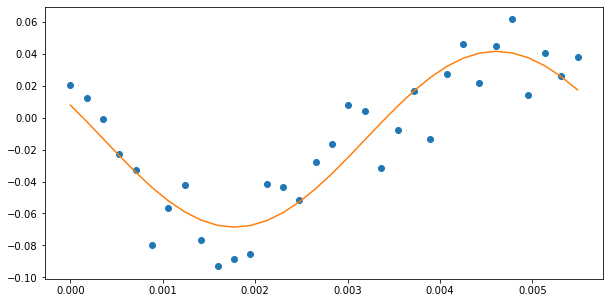

particle is:2
1108.7858571763477
Storage modulus is:298.1923613176415
Loss modulus is:145.43408498818206
R^2: 0.788672903931771
[ 0.06067829  2.68781801 -0.01406376]


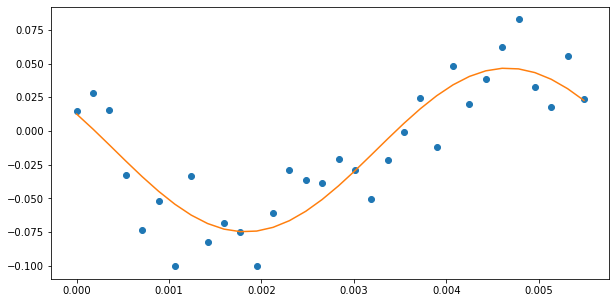

particle is:3
1144.5531428917136
Storage modulus is:267.9625895164527
Loss modulus is:159.61941653292865
R^2: 0.8989262159105595
[ 0.06454318  2.60435716 -0.00573053]


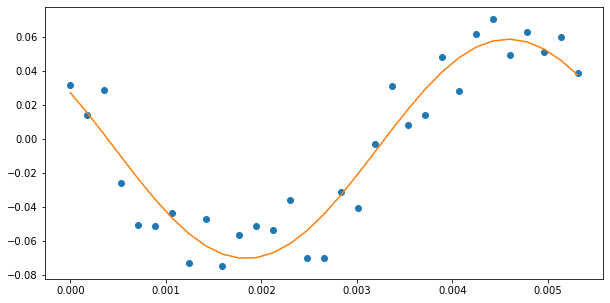

particle is:5
1108.7858571763477
Storage modulus is:297.5989910496309
Loss modulus is:194.42142606708606
R^2: 0.8099521134891112
[ 0.05663099  2.56290106 -0.04686572]


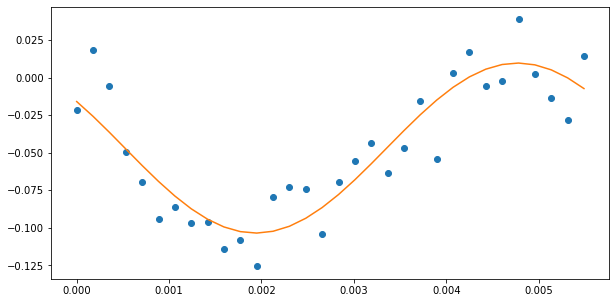

particle is:7
1108.7858571763477
Storage modulus is:306.88015311645074
Loss modulus is:150.18049079303415
R^2: 0.8213341856368895
[ 0.05892191  2.68647845 -0.02293398]


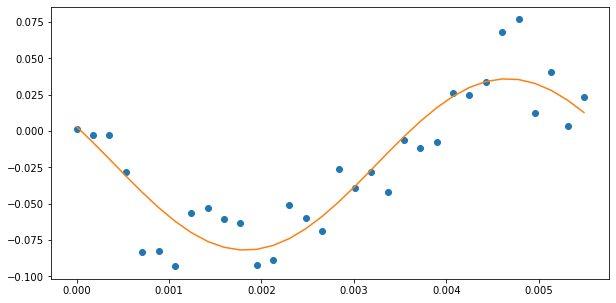

particle is:9
1108.7858571763477
Storage modulus is:277.4566615053265
Loss modulus is:200.83297000988864
R^2: 0.8071091905951544
[ 0.05877445  2.5150482  -0.0120264 ]


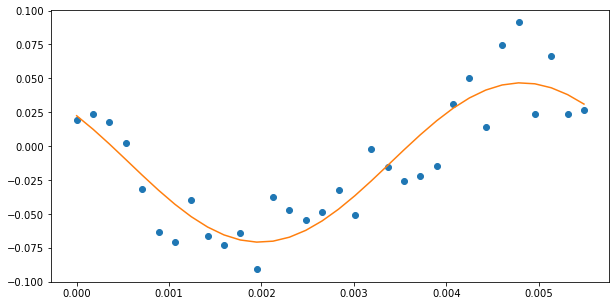

particle is:10
958.9499305308952
Storage modulus is:-1695.5364137138129
Loss modulus is:1967.4482138043043
R^2: 0.00222405060456099
[0.00775093 0.85949457 0.02384781]


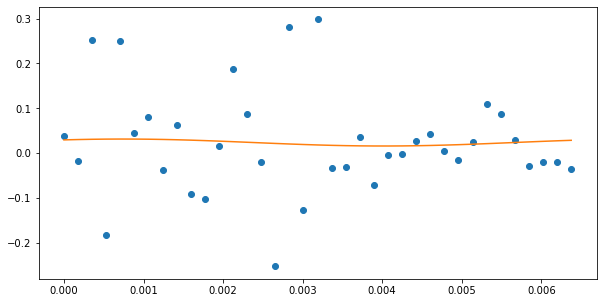

particle is:11
1144.5531428917136
Storage modulus is:295.09923242419063
Loss modulus is:166.4193496821402
R^2: 0.8718269807674867
[ 0.05942048  2.62810718 -0.00977851]


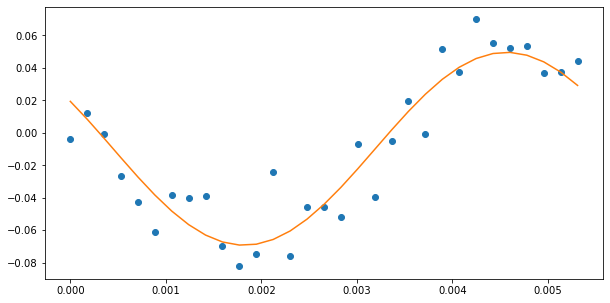

particle is:12
5068.735347091874
Storage modulus is:-1683.3012261276497
Loss modulus is:2.0614494585780412e-13
R^2: 0.2640704166297817
[1.19592921e-02 2.55566797e-17 4.84918122e-02]


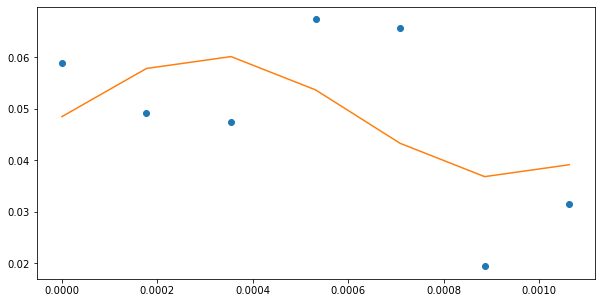

particle is:14
1108.7858571763477
Storage modulus is:267.08151510045
Loss modulus is:160.4507452817916
R^2: 0.9100260354249973
[ 0.06461141  2.60061767 -0.00778676]


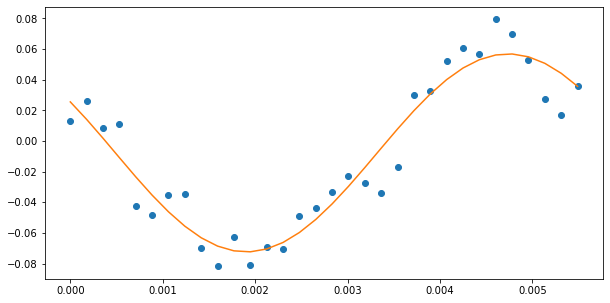

particle is:15
1108.7858571763477
Storage modulus is:281.80149703941737
Loss modulus is:154.78835975275103
R^2: 0.8442255148548968
[ 0.06261334  2.63930121 -0.02099043]


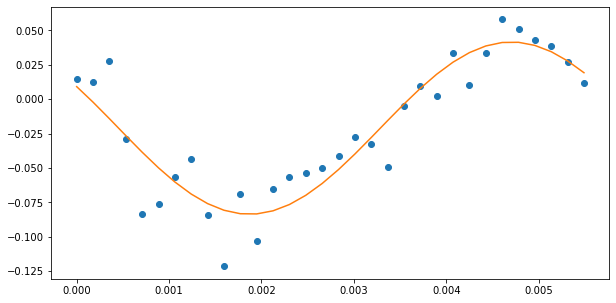

particle is:16
1108.7858571763477
Storage modulus is:312.0766187877111
Loss modulus is:150.23301770373644
R^2: 0.8194091558869735
[ 0.05812271  2.69293719 -0.00394978]


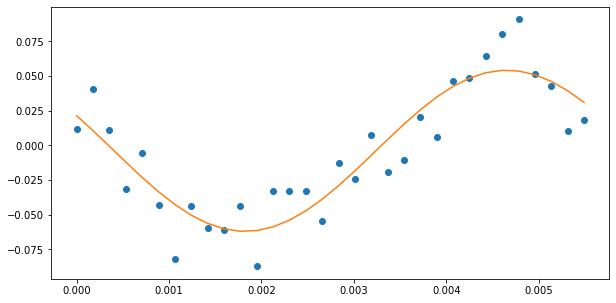

particle is:17
1182.7049143214374
Storage modulus is:347.4958858802238
Loss modulus is:108.7233148210791
R^2: 0.7880434165483502
[ 0.05528889  2.83836477 -0.03348377]


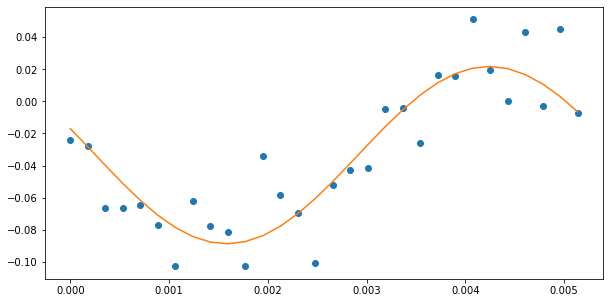

particle is:22
1144.5531428917136
Storage modulus is:278.6640375643639
Loss modulus is:134.65444326600092
R^2: 0.8922465113622935
[ 0.06504554  2.69146357 -0.00801758]


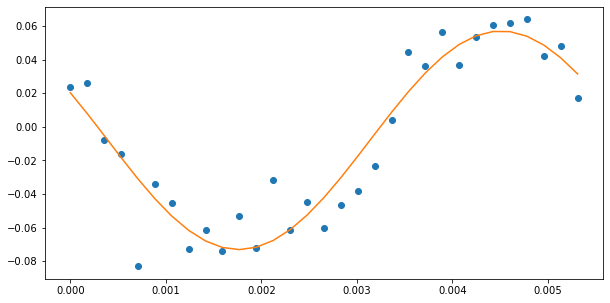

particle is:23
1108.7858571763477
Storage modulus is:243.0879830542401
Loss modulus is:206.96166554315047
R^2: 0.6048431430932826
[ 0.06305611  2.43629459 -0.06754074]


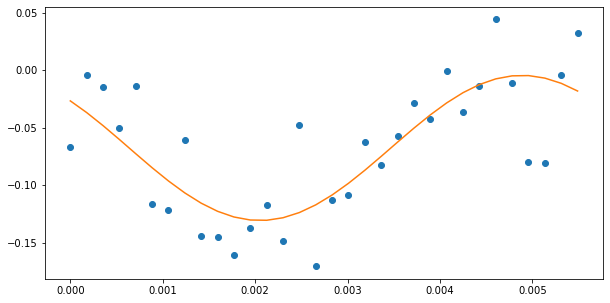

particle is:24
1144.5531428917136
Storage modulus is:431.5668388162947
Loss modulus is:201.49681326359195
R^2: 0.7468074373703381
[0.04226658 2.70477722 0.02524993]


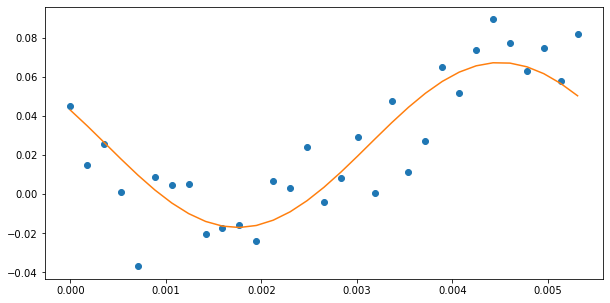

particle is:25
1144.5531428917136
Storage modulus is:260.76476658079713
Loss modulus is:86.76444471673113
R^2: 0.8983162692451891
[0.07325177 2.82038456 0.00538792]


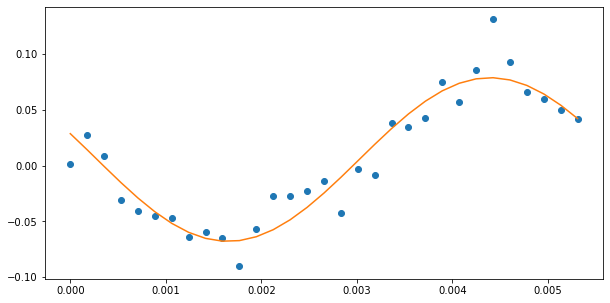

particle is:26
1144.5531428917136
Storage modulus is:277.53101688780794
Loss modulus is:159.70026447204867
R^2: 0.8667485522938105
[ 0.06287049  2.61943368 -0.005781  ]


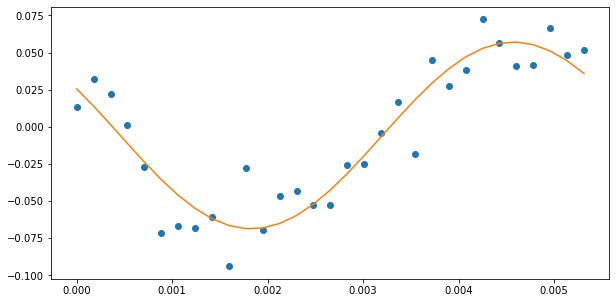

particle is:27
1108.7858571763477
Storage modulus is:412.8807582292493
Loss modulus is:199.53839300615715
R^2: 0.7570163678980194
[ 0.04389975  2.69140758 -0.01744057]


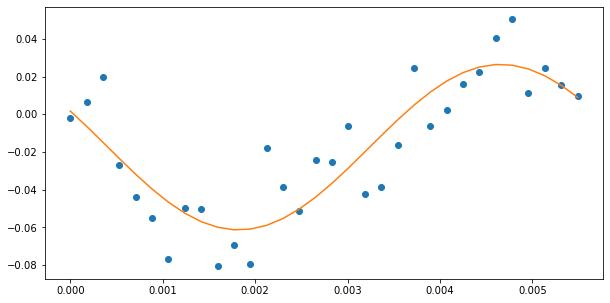

particle is:28
1144.5531428917136
Storage modulus is:291.57777768337144
Loss modulus is:254.9764228815535
R^2: 0.8131069283273026
[0.05197296 2.42306213 0.05603353]


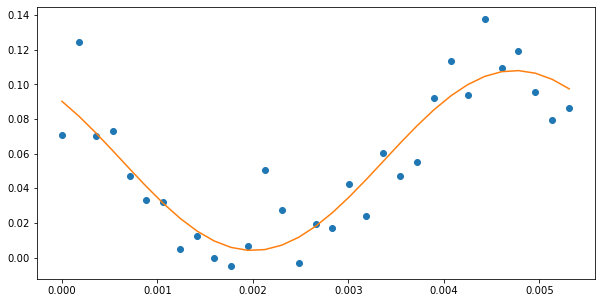

particle is:29
1108.7858571763477
Storage modulus is:301.4931195741003
Loss modulus is:165.12814152323628
R^2: 0.8181977479621775
[0.05856284 2.64051607 0.00286188]


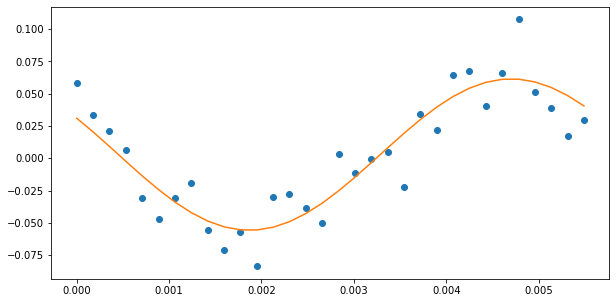

particle is:30
1108.7858571763477
Storage modulus is:301.5401743086063
Loss modulus is:148.6011582342514
R^2: 0.8180821433097389
[ 0.05988406  2.68371585 -0.00999828]


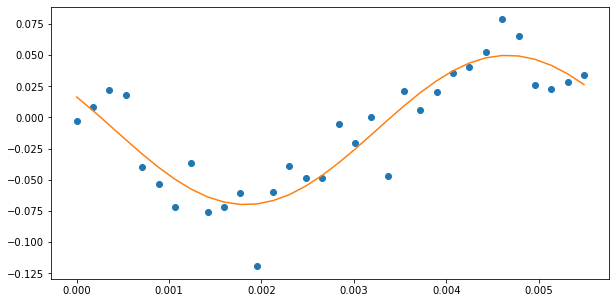

particle is:31
1144.5531428917136
Storage modulus is:213.4699045818628
Loss modulus is:583.239354368941
R^2: 0.3847445998544037
[0.03241316 1.92165984 0.00808705]


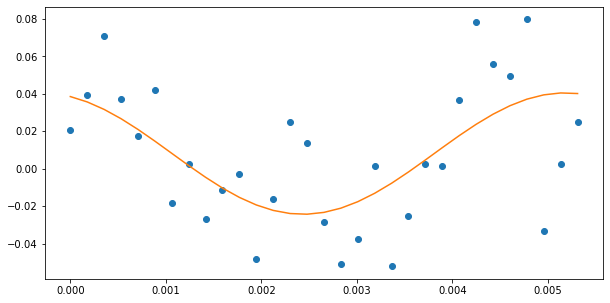

particle is:32
1108.7858571763477
Storage modulus is:313.45828373028667
Loss modulus is:165.41599086265919
R^2: 0.8763123517527931
[ 0.05679897  2.65602128 -0.00564389]


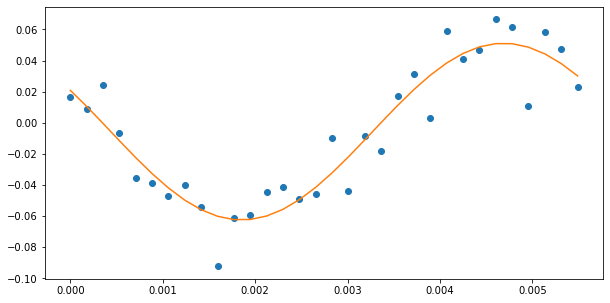

particle is:40
1144.5531428917136
Storage modulus is:292.7542516476706
Loss modulus is:180.78454402902176
R^2: 0.835381934476086
[5.85077344e-02 2.58838304e+00 8.36777489e-04]


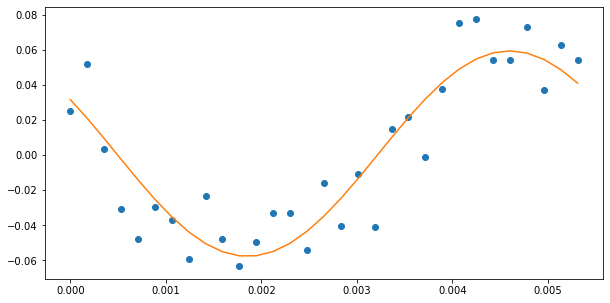

particle is:41
1108.7858571763477
Storage modulus is:279.70464577856865
Loss modulus is:200.68089007662755
R^2: 0.8674029607949405
[ 0.05847825  2.519235   -0.00530214]


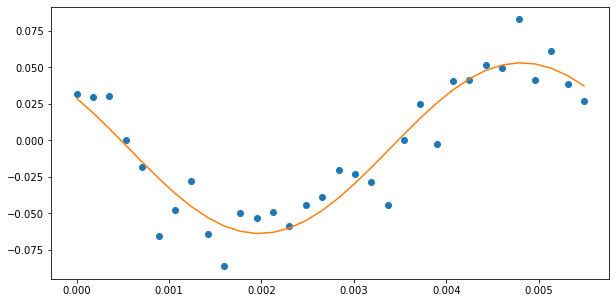

particle is:42
1144.5531428917136
Storage modulus is:264.1242678858054
Loss modulus is:160.50515192621268
R^2: 0.8961217892027586
[ 6.51346561e-02  2.59553937e+00 -2.58191201e-03]


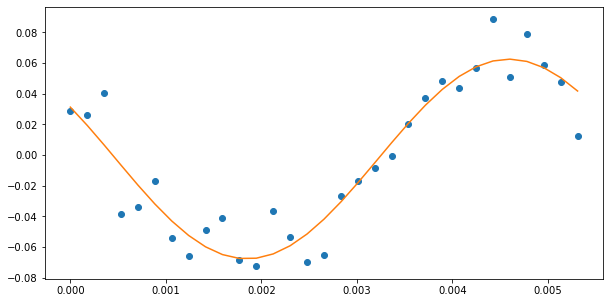

particle is:43
1144.5531428917136
Storage modulus is:285.91927848932977
Loss modulus is:193.22853040872525
R^2: 0.8236735694191044
[ 0.05833577  2.54728332 -0.01128104]


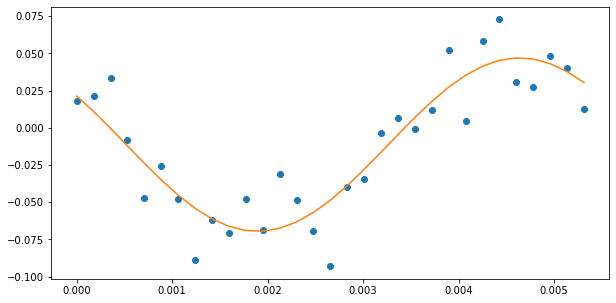

particle is:44
1108.7858571763477
Storage modulus is:247.84295875305955
Loss modulus is:180.13821919740013
R^2: 0.9102505219101821
[ 0.06570376  2.5130899  -0.02577889]


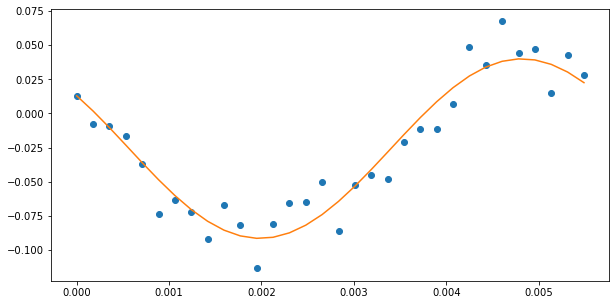

particle is:45
1144.5531428917136
Storage modulus is:118.28851431103567
Loss modulus is:143.22156148549226
R^2: 0.8449821433706715
[ 0.10837494  2.26113923 -0.06968341]


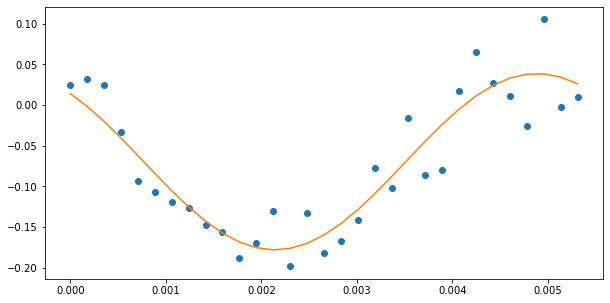

particle is:46
1144.5531428917136
Storage modulus is:317.4682882816266
Loss modulus is:171.37584178903933
R^2: 0.8236348905976246
[ 0.05580017  2.64659849 -0.00743392]


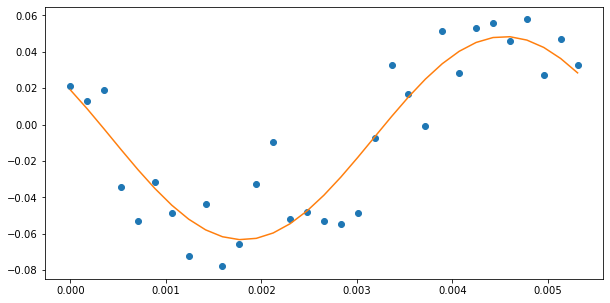

particle is:47
1144.5531428917136
Storage modulus is:231.10639784956606
Loss modulus is:159.84910921215595
R^2: 0.7868652575594988
[ 0.07164048  2.53647994 -0.00541006]


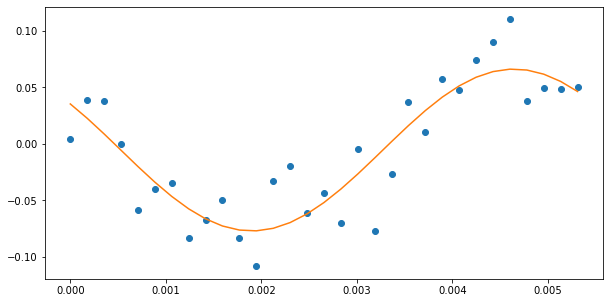

particle is:49
1223.4878424014871
Storage modulus is:178.4628351089842
Loss modulus is:150.8821336302034
R^2: 0.8140723851533295
[ 0.08614176  2.43974365 -0.01687251]


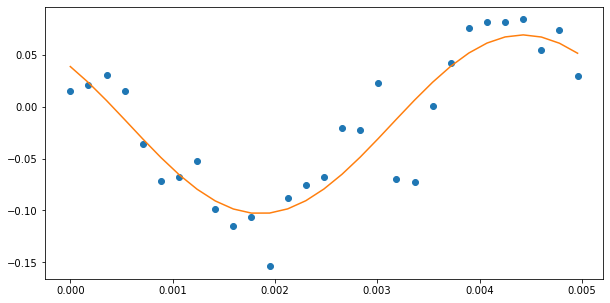

particle is:50
3225.558857240284
Storage modulus is:3040.581257021111
Loss modulus is:1.3502893279154153e-12
R^2: 0.05536092644936197
[0.0066208  3.14159265 0.04553831]


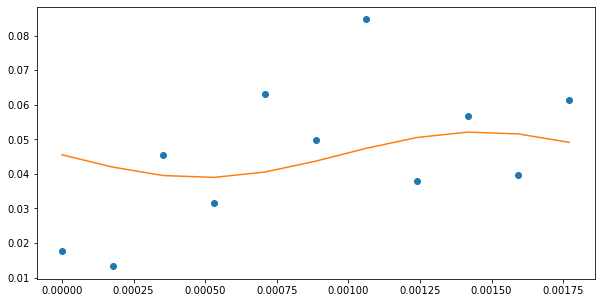

particle is:53
1314.1165714682638
Storage modulus is:402.03354535132655
Loss modulus is:187.15451368974595
R^2: 0.7497929195882356
[ 0.04539539  2.7059078  -0.01605012]


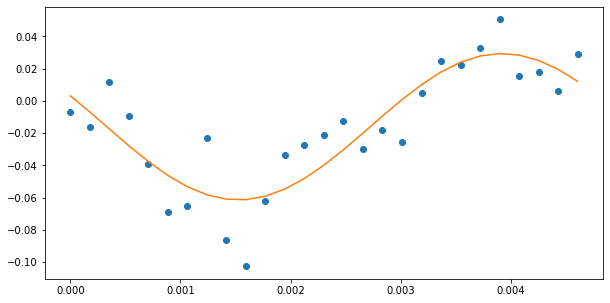

particle is:56
1108.7858571763477
Storage modulus is:261.42358410626036
Loss modulus is:185.75345151879324
R^2: 0.860232340867709
[ 0.06277291  2.52382393 -0.02691978]


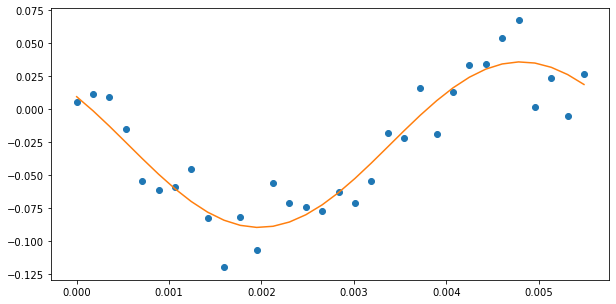

particle is:58
1108.7858571763477
Storage modulus is:268.11001306848107
Loss modulus is:306.82736356494627
R^2: 0.33245832067617676
[ 0.04940595  2.28895415 -0.03354695]


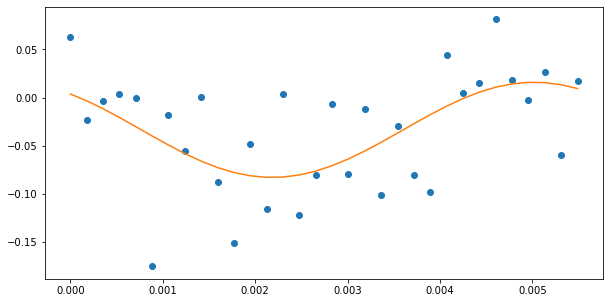

particle is:59
1144.5531428917136
Storage modulus is:308.14428175874065
Loss modulus is:207.7895839414486
R^2: 0.7752488522108703
[ 0.05416568  2.54830642 -0.00542859]


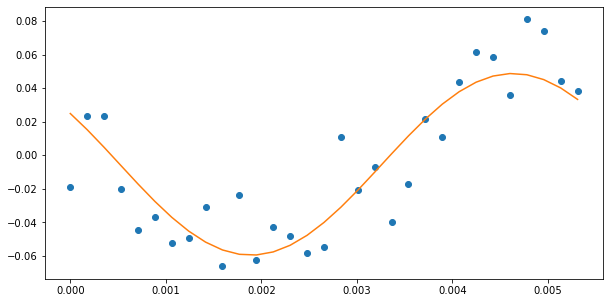

particle is:60
1108.7858571763477
Storage modulus is:343.2703732733043
Loss modulus is:239.17103935973367
R^2: 0.738155478022442
[ 0.04811738  2.53305631 -0.01122589]


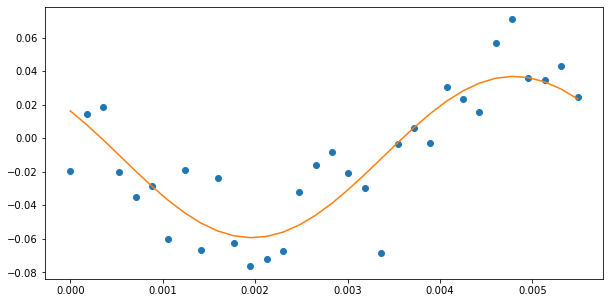

particle is:63
1144.5531428917136
Storage modulus is:270.31034218802176
Loss modulus is:175.64059665984402
R^2: 0.8866867493141178
[ 0.0624487   2.56537642 -0.00636824]


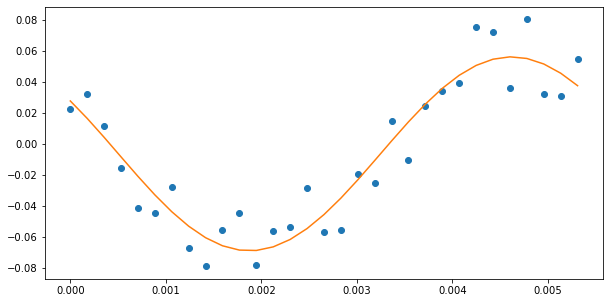

particle is:64
1144.5531428917136
Storage modulus is:315.6883901672218
Loss modulus is:201.50986500070837
R^2: 0.8155708854989482
[ 5.37516819e-02  2.57347298e+00 -2.32337413e-03]


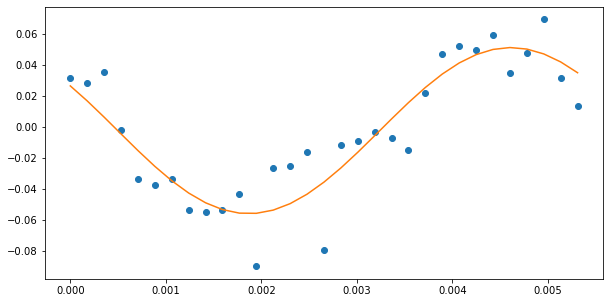

particle is:66
1075.1862857467613
Storage modulus is:236.01934347295165
Loss modulus is:190.7653565095646
R^2: 0.8770174912582536
[0.06633544 2.46183445 0.00295446]


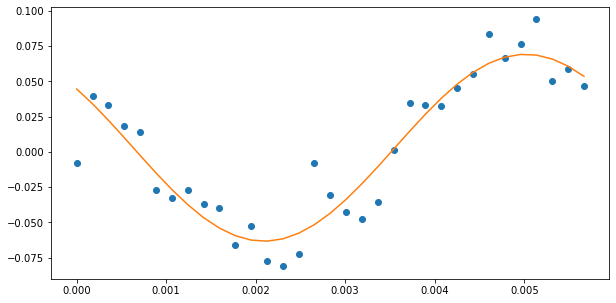

particle is:68
1144.5531428917136
Storage modulus is:273.7519352259072
Loss modulus is:123.45571099920485
R^2: 0.8878106061414299
[ 0.0670361   2.7179269  -0.00707453]


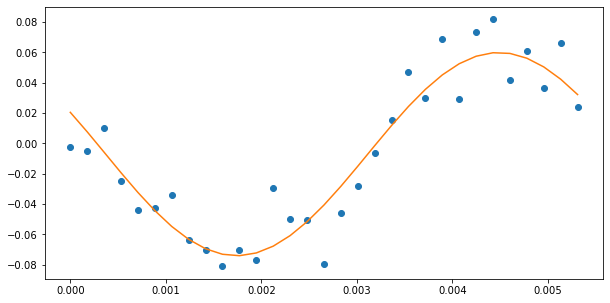

particle is:69
1144.5531428917136
Storage modulus is:222.81201223250605
Loss modulus is:159.98482652031825
R^2: 0.9014376439039896
[ 0.07339085  2.51887085 -0.01848002]


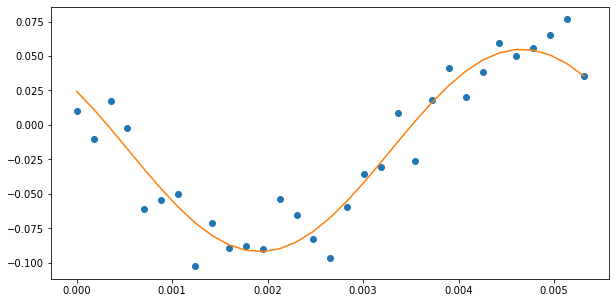

particle is:70
1108.7858571763477
Storage modulus is:336.63941845764134
Loss modulus is:172.97357625331185
R^2: 0.8290852985023002
[ 0.05318953  2.66694672 -0.01969457]


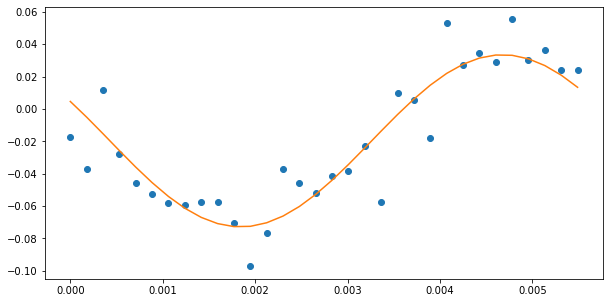

particle is:71
1223.4878424014871
Storage modulus is:1317.584455164561
Loss modulus is:5.851250396047551e-13
R^2: 0.04333027401135736
[0.01527879 3.14159265 0.0233044 ]


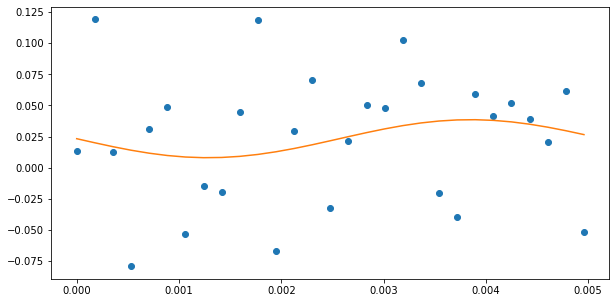

particle is:72
1108.7858571763477
Storage modulus is:288.96930550749147
Loss modulus is:197.0254978221209
R^2: 0.8633057152633511
[0.05755916 2.54317147 0.02881905]


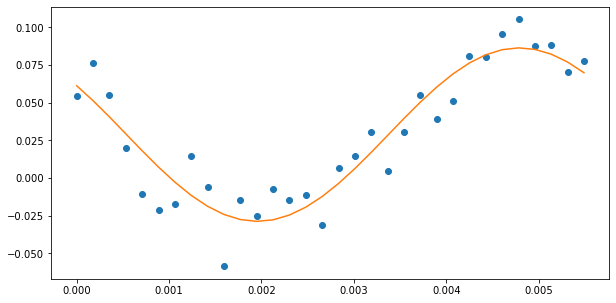

particle is:73
1144.5531428917136
Storage modulus is:301.1197119194122
Loss modulus is:174.72927184467642
R^2: 0.840809234534071
[ 0.05782424  2.61581048 -0.00951714]


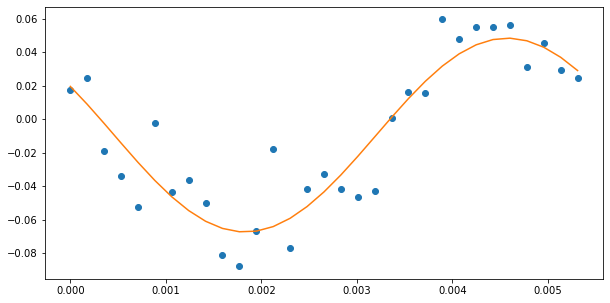

particle is:74
1144.5531428917136
Storage modulus is:243.267534111151
Loss modulus is:168.79859476572753
R^2: 0.8831740714727689
[ 0.0679887   2.53498556 -0.00287931]


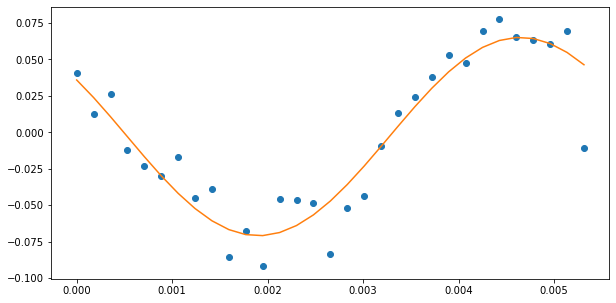

particle is:75
1108.7858571763477
Storage modulus is:221.75161053715286
Loss modulus is:171.67729579306007
R^2: 0.8838900427665901
[ 0.07178382  2.48279048 -0.01716952]


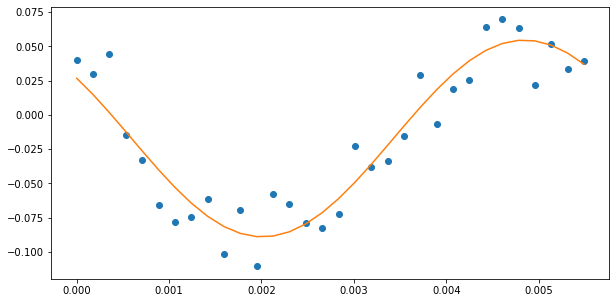

particle is:76
1108.7858571763477
Storage modulus is:304.4507240868973
Loss modulus is:158.52324653453186
R^2: 0.7901248535856068
[ 0.05864865  2.66153348 -0.01449974]


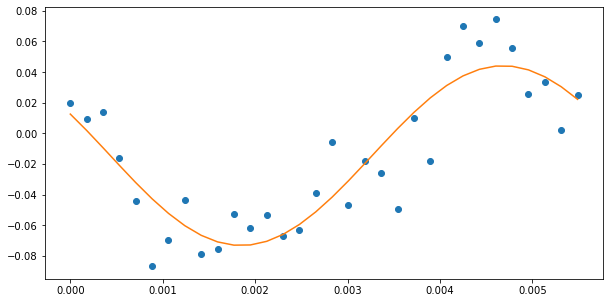

particle is:77
1144.5531428917136
Storage modulus is:205.5907855248207
Loss modulus is:142.01585497365545
R^2: 0.8552479259592503
[ 0.08056558  2.53708852 -0.04783369]


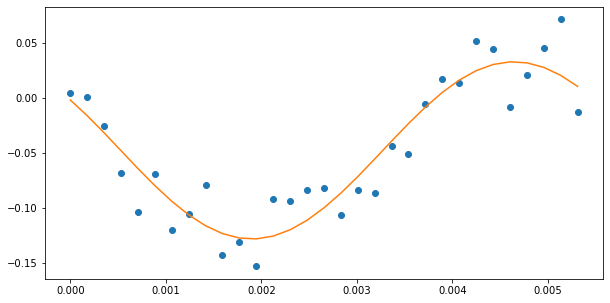

particle is:78
1108.7858571763477
Storage modulus is:172.56048422714102
Loss modulus is:132.36854707739866
R^2: 0.9116823317966615
[ 0.09256427  2.48724656 -0.01445939]


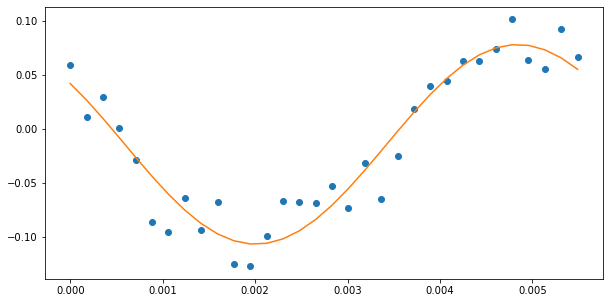

particle is:80
2534.367673545937
Storage modulus is:613.5372211533847
Loss modulus is:2.7246525975560975e-13
R^2: 0.3705433311781534
[0.03281152 3.14159265 0.0378283 ]


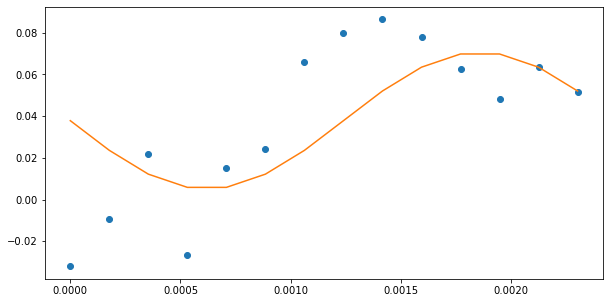

particle is:81
1108.7858571763477
Storage modulus is:343.56445978329583
Loss modulus is:216.21246311035264
R^2: 0.7157570286232875
[ 0.04959174  2.57989186 -0.01171655]


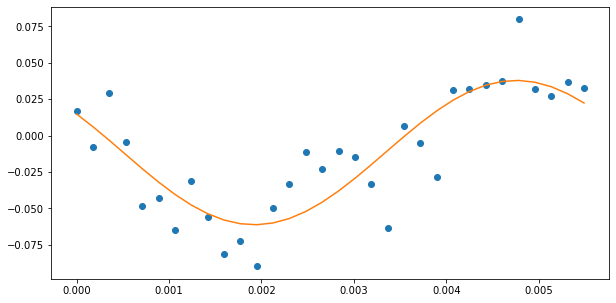

particle is:82
1108.7858571763477
Storage modulus is:283.4675528554173
Loss modulus is:182.90203693345345
R^2: 0.8508337291000374
[ 0.05967368  2.56857733 -0.0307982 ]


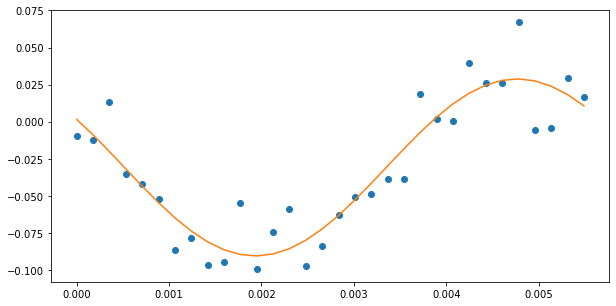

particle is:83
1075.1862857467613
Storage modulus is:225.6184951189647
Loss modulus is:180.3246061622273
R^2: 0.563461971053896
[ 0.06969963  2.46731184 -0.01680043]


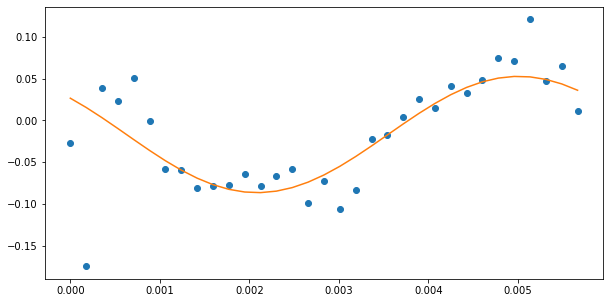

particle is:93
1144.5531428917136
Storage modulus is:205.13239346642033
Loss modulus is:132.96907815442805
R^2: 0.9024620533529283
[ 0.08234965  2.56647609 -0.03892244]


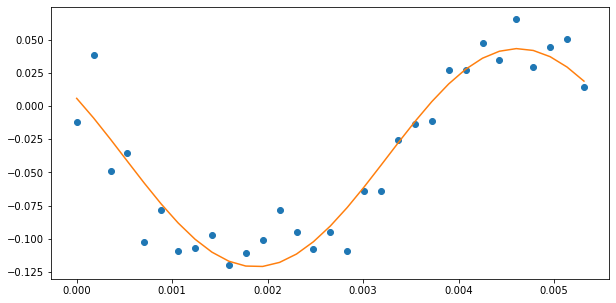

particle is:94
1144.5531428917136
Storage modulus is:218.9461758541337
Loss modulus is:132.30477779485417
R^2: 0.8949159207532033
[ 0.07869354  2.59803209 -0.00751094]


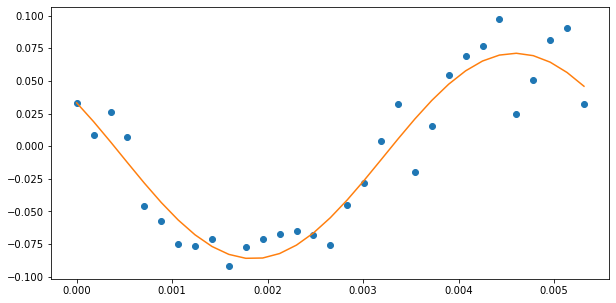

particle is:95
1144.5531428917136
Storage modulus is:318.062665983486
Loss modulus is:152.45285530134277
R^2: 0.80081360475425
[ 0.05707516  2.6946279  -0.00486705]


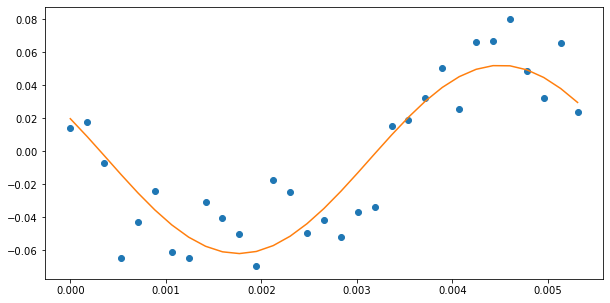

particle is:96
1108.7858571763477
Storage modulus is:337.4052323284881
Loss modulus is:196.1427457583454
R^2: 0.8194016498805345
[ 0.05158186  2.61501652 -0.00570085]


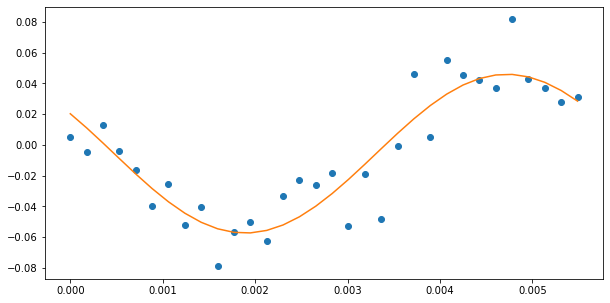

particle is:97
1108.7858571763477
Storage modulus is:293.0227854875442
Loss modulus is:135.038777173112
R^2: 0.8523046454129992
[ 0.06239453  2.70975477 -0.01046367]


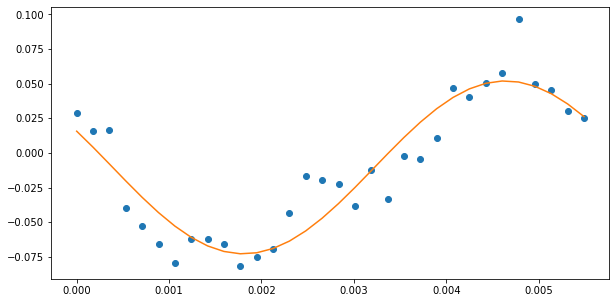

particle is:98
1144.5531428917136
Storage modulus is:216.17914560465636
Loss modulus is:144.4105272242406
R^2: 0.8874967434544087
[ 7.74342475e-02  2.55265840e+00 -2.13033276e-03]


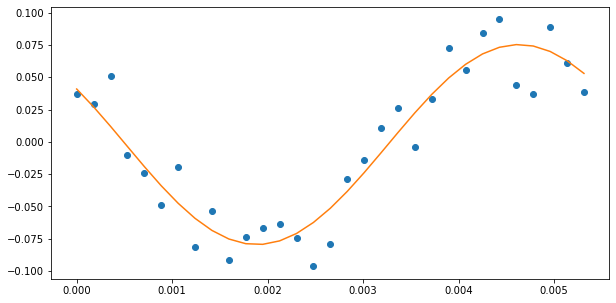

particle is:99
1144.5531428917136
Storage modulus is:328.32040134059145
Loss modulus is:153.7615604623971
R^2: 0.7977977816408046
[0.05552757 2.70360232 0.00820333]


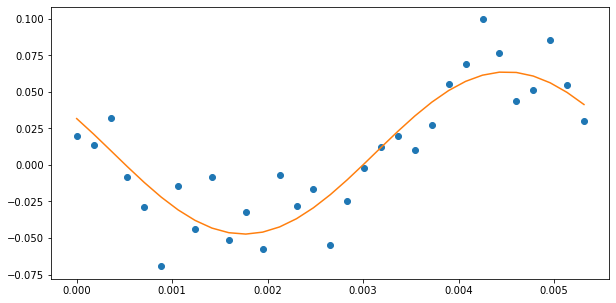

particle is:100
1108.7858571763477
Storage modulus is:165.07329909186373
Loss modulus is:131.99973410464204
R^2: 0.8628452696940605
[0.09524543 2.46706934 0.07693103]


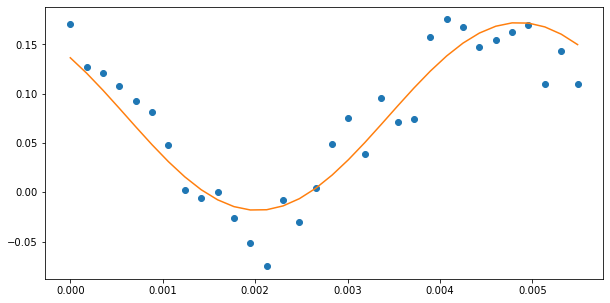

particle is:101
1144.5531428917136
Storage modulus is:398.353842770281
Loss modulus is:214.4149431125691
R^2: 0.7452464454727993
[ 0.04449911  2.64781337 -0.00413394]


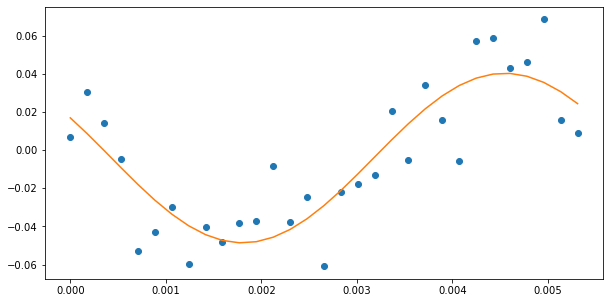

particle is:102
1108.7858571763477
Storage modulus is:309.46984146353077
Loss modulus is:104.89422007539362
R^2: 0.8766930116763363
[ 6.16075280e-02  2.81479733e+00 -2.68681122e-03]


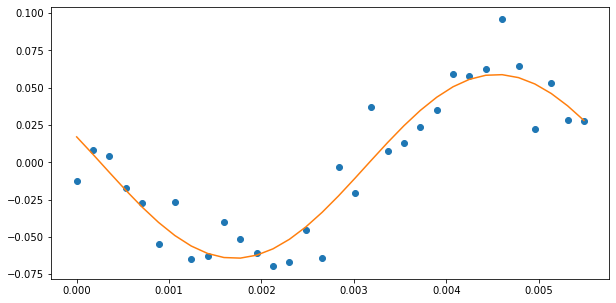

particle is:103
1144.5531428917136
Storage modulus is:338.7879815654355
Loss modulus is:120.94119225568235
R^2: 0.8364800829634629
[5.59620155e-02 2.79871143e+00 1.96513867e-03]


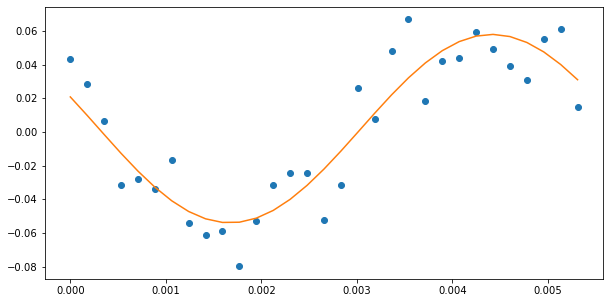

particle is:104
1144.5531428917136
Storage modulus is:272.02002499947366
Loss modulus is:180.07721366755334
R^2: 0.8569146264711358
[ 0.06170924  2.55682789 -0.00694398]


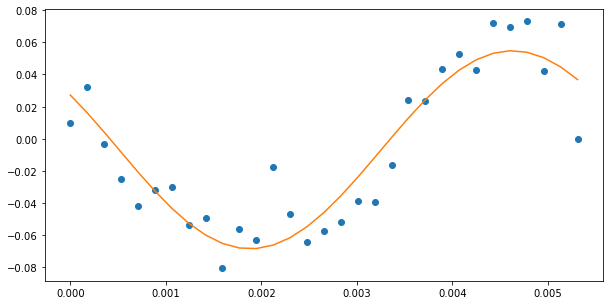

particle is:106
1144.5531428917136
Storage modulus is:309.8929856192991
Loss modulus is:131.0169206174386
R^2: 0.8503359751473506
[ 0.0598337   2.74160287 -0.01332902]


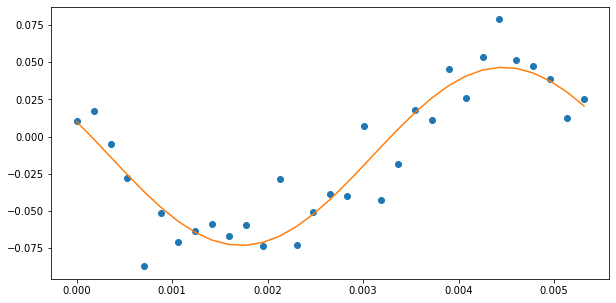

particle is:108
909.7730110164904
Storage modulus is:136.42033434601584
Loss modulus is:6.058279848720353e-14
R^2: 0.5188202121079379
[0.14756664 3.14159265 0.09937281]


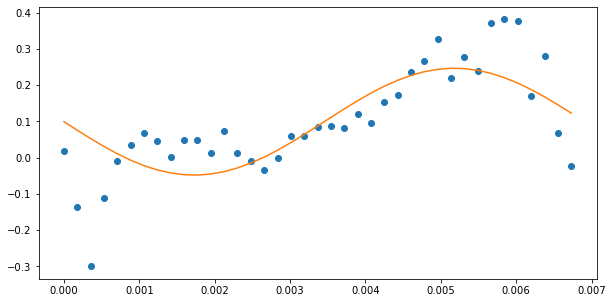

particle is:109
1689.5784490306248
Storage modulus is:421.5145981267774
Loss modulus is:1.8719008482238726e-13
R^2: 0.5554876763499568
[0.04775894 3.14159265 0.00354294]


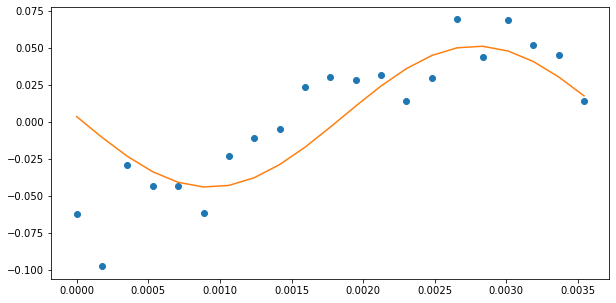

particle is:110
1108.7858571763477
Storage modulus is:121.25259408616971
Loss modulus is:153.03210431383758
R^2: 0.7519172872383681
[0.10310627 2.24084559 0.09999999]


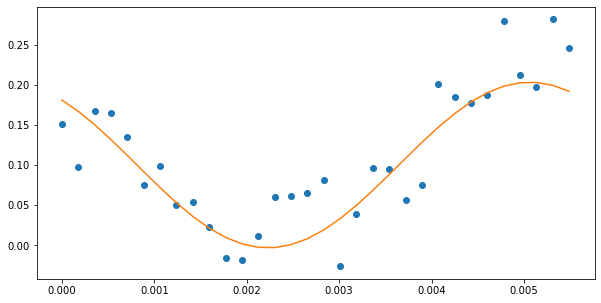

In [63]:
data1=utils.analyze_wavelength_modulus(wavelength1,gamma2list_w1,real_stress,framerate,imgname)

In [64]:
data1

,Droplet Number,Storage Modulus,Loss Modulus,Frequency,R^2,Video Name
0,1,336.770685,142.271170,1108.785857,0.816142,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
2,3,267.962590,159.619417,1144.553143,0.898926,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
3,5,297.598991,194.421426,1108.785857,0.809952,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
4,7,306.880153,150.180491,1108.785857,0.821334,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
5,9,277.456662,200.832970,1108.785857,0.807109,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
7,11,295.099232,166.419350,1144.553143,0.871827,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
9,14,267.081515,160.450745,1108.785857,0.910026,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
10,15,281.801497,154.788360,1108.785857,0.844226,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
11,16,312.076619,150.233018,1108.785857,0.819409,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...
13,22,278.664038,134.654443,1144.553143,0.892247,0p5low_alg_12p5mM_3500ul_100um_20231013_120530...


## wavelegnth 2

In [65]:
wavelength2=t1_modified[(t1_modified['x'] >= 506) & (t1_modified['x'] <= 1002)]

In [66]:
gamma2list_w2=utils.analyze_wavelength_gamma2(wavelength2,2,imgname,img_tif,ref)

particle number: 1
frame number is87
frame number is88


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is89
frame number is90
frame number is91
frame number is92
frame number is93
frame number is94
frame number is95
frame number is96
frame number is97
frame number is98
frame number is99
frame number is100
frame number is101
frame number is102
frame number is103


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is104
frame number is105
frame number is106
frame number is107
frame number is108


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is109
frame number is110
frame number is111
frame number is112
frame number is113
frame number is114
frame number is115


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is116
frame number is117


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is118
frame number is119
frame number is120
frame number is121


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 2
frame number is205
frame number is206
frame number is207
frame number is208


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is209
frame number is210
frame number is211
frame number is212
frame number is213
frame number is214
frame number is215
frame number is216


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is217
frame number is218


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is219
frame number is220
frame number is221
frame number is222
frame number is223
frame number is224
frame number is225
frame number is226


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is227
frame number is228
frame number is229
frame number is230
frame number is231
frame number is232


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is233
frame number is234
frame number is235
frame number is236
frame number is237
frame number is238
frame number is239
particle number: 3
frame number is239
frame number is240
frame number is241


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is242
frame number is243
frame number is244
frame number is245
frame number is246
frame number is247
frame number is248
frame number is249
frame number is250
frame number is251
frame number is252
frame number is253


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is254
frame number is255
frame number is256
frame number is257


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is258
frame number is259


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is260
frame number is261
frame number is262
frame number is263
frame number is264


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is265
frame number is266
frame number is267


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is268
frame number is269
frame number is270
frame number is271
frame number is272


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is273
particle number: 5
frame number is328
frame number is329
frame number is330
frame number is331
frame number is332


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is333
frame number is334


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is335
frame number is336
frame number is337
frame number is338
frame number is339
frame number is340


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is341
frame number is342
frame number is343
frame number is344
frame number is345
frame number is346


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is347
frame number is348
frame number is349
frame number is350


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is351
particle number: 7
frame number is360


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is361
frame number is362
frame number is363
frame number is364
frame number is365
frame number is366
frame number is367
frame number is368


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is369
frame number is370
frame number is371
frame number is372
frame number is373
frame number is374
frame number is375
frame number is376
frame number is377
frame number is378
frame number is379


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is380
frame number is381
frame number is382
frame number is383
frame number is384
frame number is385


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is386
frame number is387
frame number is388
frame number is389


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is390
frame number is391
frame number is392
frame number is393
frame number is394
particle number: 9
frame number is623
frame number is624
frame number is625


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is626
frame number is627
frame number is628
frame number is629
frame number is630
frame number is631


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is632
frame number is633
frame number is634
frame number is635
frame number is636
frame number is637


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is638
frame number is639
frame number is640
frame number is641
frame number is642
frame number is643


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is644
frame number is645
frame number is646
frame number is647
frame number is648
frame number is649


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is650
frame number is651
frame number is652
frame number is653


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is654
frame number is655
frame number is656
particle number: 12
frame number is796
frame number is797
frame number is798


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is799
frame number is800
frame number is801
frame number is802
frame number is803
frame number is804
frame number is805
frame number is806
frame number is807
frame number is808
frame number is809
frame number is810
frame number is811
frame number is812


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is813
frame number is814
frame number is815
frame number is816
frame number is817
frame number is818
frame number is819
frame number is820
frame number is821
frame number is822
frame number is823
frame number is824


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is825
frame number is826
frame number is827
frame number is828
frame number is829
frame number is830
particle number: 10
frame number is801
frame number is802


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is803
frame number is804


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is805
frame number is806
frame number is807
frame number is808


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is809
frame number is810
frame number is811
frame number is812


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is813
frame number is814


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is815
frame number is816


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is817
frame number is818
frame number is819
frame number is820
particle number: 11
frame number is806
frame number is807
frame number is808
frame number is809
frame number is810
frame number is811
frame number is812
frame number is813
frame number is814
frame number is815
frame number is816
particle number: 14
frame number is898
frame number is899
frame number is900
frame number is901


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is902
frame number is903
frame number is904
frame number is905
frame number is906
frame number is907
frame number is908
frame number is909


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is910
frame number is911


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is912
frame number is913
frame number is914
frame number is915


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is916
frame number is917
frame number is918
frame number is919


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is920
frame number is921
frame number is922
frame number is923
frame number is924
frame number is925
frame number is926
frame number is927
frame number is928
frame number is929


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is930
frame number is931
particle number: 15
frame number is1002
frame number is1003
frame number is1004
frame number is1005
frame number is1006
frame number is1007
frame number is1008
frame number is1009


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1010
frame number is1011
frame number is1012
frame number is1013


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1014
frame number is1015
frame number is1016
frame number is1017
frame number is1018
frame number is1019
frame number is1020
frame number is1021


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1022
frame number is1023
frame number is1024
frame number is1025


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1026
frame number is1027
frame number is1028
frame number is1029
frame number is1030
frame number is1031
frame number is1032
frame number is1033
frame number is1034
frame number is1035
frame number is1036
particle number: 16
frame number is1059
frame number is1060
frame number is1061
frame number is1062
frame number is1063


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1064
frame number is1065
frame number is1066
frame number is1067


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1068
frame number is1069
frame number is1070
frame number is1071


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1072
frame number is1073
frame number is1074
frame number is1075
frame number is1076
frame number is1077
frame number is1078
frame number is1079


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1080
frame number is1081
frame number is1082
frame number is1083
frame number is1084
frame number is1085
frame number is1086
frame number is1087
frame number is1088
frame number is1089
frame number is1090
frame number is1091
frame number is1092
particle number: 17
frame number is1162
frame number is1163
frame number is1164
frame number is1165
frame number is1166


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1167
frame number is1168


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1169
frame number is1170
frame number is1171
frame number is1172


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1173
frame number is1174
frame number is1175
frame number is1176
particle number: 22
frame number is1378
frame number is1379
frame number is1380
frame number is1381
frame number is1382
frame number is1383
frame number is1384
frame number is1385
frame number is1386
frame number is1387
frame number is1388
frame number is1389
frame number is1390
frame number is1391


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1392
frame number is1393


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1394
frame number is1395
frame number is1396
frame number is1397


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1398
frame number is1399
frame number is1400
frame number is1401
frame number is1402
frame number is1403


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1404
frame number is1405
frame number is1406
frame number is1407
frame number is1408
frame number is1409
frame number is1410
frame number is1411


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1412
particle number: 23
frame number is1407
frame number is1408
frame number is1409


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1410
frame number is1411
frame number is1412
frame number is1413


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1414
frame number is1415
frame number is1416
frame number is1417
frame number is1418
frame number is1419
frame number is1420
frame number is1421


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1422
frame number is1423
frame number is1424
frame number is1425


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1426
frame number is1427
frame number is1428
frame number is1429
frame number is1430
frame number is1431


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1432
frame number is1433
frame number is1434
frame number is1435


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1436
frame number is1437
frame number is1438
frame number is1439
frame number is1440
frame number is1441
particle number: 24
frame number is1687
frame number is1688
frame number is1689
frame number is1690


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1691
frame number is1692
frame number is1693
frame number is1694


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1695
frame number is1696
frame number is1697
frame number is1698
frame number is1699
frame number is1700


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1701
frame number is1702


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1703
frame number is1704
frame number is1705
frame number is1706
frame number is1707
frame number is1708


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1709
frame number is1710
frame number is1711
frame number is1712
frame number is1713
frame number is1714
frame number is1715
frame number is1716
frame number is1717
frame number is1718
frame number is1719
frame number is1720
frame number is1721
particle number: 25
frame number is1702


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1703
frame number is1704
frame number is1705
frame number is1706
frame number is1707
frame number is1708
frame number is1709
frame number is1710
frame number is1711
frame number is1712
frame number is1713
frame number is1714
frame number is1715
frame number is1716
frame number is1717
frame number is1718
frame number is1719
frame number is1720


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1721
frame number is1722
frame number is1723
frame number is1724
frame number is1725
frame number is1726
frame number is1727
frame number is1728
frame number is1729
frame number is1730
frame number is1731
frame number is1732
frame number is1733
frame number is1734
frame number is1735
frame number is1736
particle number: 26
frame number is1789
frame number is1790
frame number is1791
frame number is1792
frame number is1793
frame number is1794
frame number is1795
frame number is1796


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1797
frame number is1798


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1799
frame number is1800


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1801
frame number is1802


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1803
frame number is1804
frame number is1805
frame number is1806
frame number is1807
frame number is1808
frame number is1809
frame number is1810
frame number is1811
frame number is1812
frame number is1813
frame number is1814
frame number is1815
frame number is1816
frame number is1817
frame number is1818
frame number is1819
frame number is1820
frame number is1821
frame number is1822
frame number is1823
particle number: 27
frame number is1800
frame number is1801


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1802
frame number is1803
frame number is1804
frame number is1805
frame number is1806
frame number is1807
frame number is1808
frame number is1809
frame number is1810
frame number is1811
frame number is1812
frame number is1813
frame number is1814
frame number is1815


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1816
frame number is1817
frame number is1818
frame number is1819
frame number is1820
frame number is1821
frame number is1822
frame number is1823
frame number is1824
frame number is1825
frame number is1826
frame number is1827
frame number is1828
frame number is1829


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1830
frame number is1831
frame number is1832
frame number is1833


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1834
particle number: 28
frame number is1807
frame number is1808
frame number is1809
frame number is1810
frame number is1811
frame number is1812
frame number is1813
frame number is1814
frame number is1815
frame number is1816
frame number is1817
frame number is1818
frame number is1819
frame number is1820
frame number is1821
frame number is1822
frame number is1823
frame number is1824
frame number is1825
frame number is1826
frame number is1827


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1828
frame number is1829
frame number is1830
frame number is1831
frame number is1832
frame number is1833
frame number is1834
frame number is1835


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1836
frame number is1837
frame number is1838
frame number is1839
frame number is1840
frame number is1841
particle number: 29
frame number is1865
frame number is1866
frame number is1867
frame number is1868
frame number is1869
frame number is1870
frame number is1871
frame number is1872
frame number is1873
frame number is1874
frame number is1875
frame number is1876


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1877
frame number is1878
frame number is1879
frame number is1880
frame number is1881
frame number is1882
frame number is1883
frame number is1884
frame number is1885
frame number is1886


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1887
frame number is1888
frame number is1889
frame number is1890
frame number is1891
frame number is1892


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1893
frame number is1894
frame number is1895
frame number is1896
frame number is1897
frame number is1898
particle number: 30
frame number is1931
frame number is1932


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1933
frame number is1934
frame number is1935
frame number is1936
frame number is1937
frame number is1938
frame number is1939
frame number is1940
frame number is1941
frame number is1942


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1943
frame number is1944
frame number is1945
frame number is1946


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is1947
frame number is1948
frame number is1949
frame number is1950


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1951
frame number is1952
frame number is1953
frame number is1954
frame number is1955
frame number is1956


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1957
frame number is1958
frame number is1959
frame number is1960


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1961
frame number is1962
frame number is1963
frame number is1964


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 31
frame number is1941
frame number is1942
frame number is1943
frame number is1944
frame number is1945
frame number is1946
frame number is1947
frame number is1948
frame number is1949
frame number is1950
frame number is1951
frame number is1952


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1953
frame number is1954
frame number is1955
frame number is1956
frame number is1957
frame number is1958
frame number is1959
frame number is1960
frame number is1961
frame number is1962
frame number is1963
frame number is1964


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1965
frame number is1966
frame number is1967
frame number is1968


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1969
frame number is1970
frame number is1971
frame number is1972
frame number is1973
frame number is1974


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is1975
particle number: 32
frame number is2026


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2027
frame number is2028
frame number is2029
frame number is2030


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2031
frame number is2032
frame number is2033
frame number is2034
frame number is2035
frame number is2036
frame number is2037
frame number is2038


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2039
frame number is2040
frame number is2041
frame number is2042


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2043
frame number is2044
frame number is2045
frame number is2046
frame number is2047
frame number is2048


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2049
frame number is2050


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2051
frame number is2052
frame number is2053
frame number is2054
frame number is2055
frame number is2056
frame number is2057
frame number is2058
frame number is2059
frame number is2060


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 40
frame number is2163
frame number is2164
frame number is2165


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2166
frame number is2167
frame number is2168
frame number is2169
frame number is2170


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2171
frame number is2172
frame number is2173
frame number is2174


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2175
frame number is2176
frame number is2177
frame number is2178
frame number is2179
frame number is2180
frame number is2181


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2182
frame number is2183
frame number is2184
frame number is2185
frame number is2186


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2187
frame number is2188
frame number is2189
frame number is2190


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2191
frame number is2192
frame number is2193
frame number is2194
frame number is2195
frame number is2196
frame number is2197
particle number: 41
frame number is2206
frame number is2207


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2208
frame number is2209
frame number is2210
frame number is2211
frame number is2212
frame number is2213
frame number is2214
frame number is2219
frame number is2220
frame number is2221


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2222
frame number is2223
frame number is2224
frame number is2225
frame number is2226
frame number is2227


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2228
frame number is2229
frame number is2230
frame number is2231
frame number is2232
frame number is2233
frame number is2234


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2235
frame number is2236
frame number is2237
frame number is2238
frame number is2239
frame number is2240
particle number: 42
frame number is2436


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2437
frame number is2438
frame number is2439
frame number is2440
frame number is2441
frame number is2442
frame number is2443
frame number is2444
frame number is2445
frame number is2446
frame number is2447
frame number is2448


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2449
frame number is2450
frame number is2451
frame number is2452
frame number is2453
frame number is2454


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2455
frame number is2456
frame number is2457
frame number is2458


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2459
frame number is2460


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2461
frame number is2462
frame number is2463
frame number is2464


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2465
frame number is2466
frame number is2467
frame number is2468


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2469
frame number is2470
particle number: 43
frame number is2582
frame number is2583
frame number is2584


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2585
frame number is2586
frame number is2587
frame number is2588
frame number is2589
frame number is2590
frame number is2591
frame number is2592
frame number is2593
frame number is2594
frame number is2595
frame number is2596
frame number is2597
frame number is2598
frame number is2599
frame number is2600


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2601
frame number is2602


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2603
frame number is2604
frame number is2605
frame number is2606
frame number is2607
frame number is2608


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2609
frame number is2610
frame number is2611
frame number is2612
frame number is2613
frame number is2614
frame number is2615
frame number is2616
particle number: 44
frame number is2594
frame number is2595


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2596
frame number is2597
frame number is2598
frame number is2599
frame number is2600
frame number is2601
frame number is2602
frame number is2603


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2604
frame number is2605
frame number is2606
frame number is2607
frame number is2608
frame number is2609


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2610
frame number is2611
frame number is2612
frame number is2613
frame number is2614
frame number is2615
frame number is2616
frame number is2617


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2618
frame number is2619


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2620
frame number is2621


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2622
frame number is2623
frame number is2624
frame number is2625
frame number is2626
frame number is2627
frame number is2628
particle number: 45
frame number is2666
frame number is2667
frame number is2668
frame number is2669
frame number is2670
frame number is2671
frame number is2672
frame number is2673
frame number is2674
frame number is2675
frame number is2676
frame number is2677
frame number is2678
frame number is2679
frame number is2680


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2681
frame number is2682
frame number is2683
frame number is2684


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2685
frame number is2686


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2687
frame number is2688
frame number is2689
frame number is2690
frame number is2691
frame number is2692


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2693
frame number is2694
frame number is2695
frame number is2696


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2697
frame number is2698
frame number is2699
frame number is2700
frame number is2701
particle number: 46
frame number is2681
frame number is2682
frame number is2683


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2684
frame number is2685
frame number is2686
frame number is2687
frame number is2688
frame number is2689
frame number is2690
frame number is2691
frame number is2692
frame number is2693
frame number is2694
frame number is2695


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2696
frame number is2697
frame number is2698
frame number is2699


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2700
frame number is2701
frame number is2702
frame number is2703
frame number is2704
frame number is2705
frame number is2706
frame number is2707
frame number is2708
frame number is2709


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2710
frame number is2711
frame number is2712
frame number is2713
frame number is2714
frame number is2715
particle number: 47
frame number is2697
frame number is2698


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2699
frame number is2700
frame number is2701
frame number is2702
frame number is2703
frame number is2704
frame number is2705
frame number is2706
frame number is2707
frame number is2708
frame number is2709
frame number is2710
frame number is2711
frame number is2712
frame number is2713
frame number is2714


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2715
frame number is2716
frame number is2717
frame number is2718
frame number is2719
frame number is2720
frame number is2721
frame number is2722
frame number is2723
frame number is2724
frame number is2725
frame number is2726
frame number is2727
frame number is2728
frame number is2729
frame number is2730
particle number: 49
frame number is2722
frame number is2723
frame number is2724
frame number is2725
frame number is2726
frame number is2727
frame number is2728
frame number is2729
frame number is2730
frame number is2731


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2732
particle number: 50
frame number is2725


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2726
frame number is2727
frame number is2728
frame number is2729
frame number is2730
frame number is2731
frame number is2732
frame number is2733


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2734
frame number is2735
frame number is2736
frame number is2737
frame number is2738
frame number is2739


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2740
frame number is2741


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2742
frame number is2743


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is2744
frame number is2745
frame number is2746
frame number is2747
frame number is2748
frame number is2749


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2750
frame number is2751


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2752
frame number is2753
frame number is2754
frame number is2755
frame number is2756
frame number is2757


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2758
frame number is2759
particle number: 53
frame number is2809
frame number is2810
frame number is2811
frame number is2812
frame number is2813
frame number is2814
frame number is2815


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2816
frame number is2817
frame number is2818
frame number is2819


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2820
frame number is2821


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2822
frame number is2823
frame number is2824
frame number is2825


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2826
frame number is2827


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2828
frame number is2829
frame number is2830
frame number is2831


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2832
frame number is2833
frame number is2834
frame number is2835


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2836
frame number is2837


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2838
frame number is2839
frame number is2840
frame number is2841
frame number is2842
particle number: 56
frame number is2851
frame number is2852
frame number is2853
frame number is2854
frame number is2855
frame number is2856
frame number is2857


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2858
frame number is2859


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2860
frame number is2861
frame number is2862
frame number is2863
frame number is2864
frame number is2865
frame number is2866
frame number is2867
frame number is2868
frame number is2869
frame number is2870
frame number is2871
frame number is2872
frame number is2873
frame number is2874
frame number is2875
frame number is2876
frame number is2877


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2878
frame number is2879
frame number is2880
frame number is2881
frame number is2882
frame number is2883


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is2884
frame number is2885
particle number: 58
frame number is3046
frame number is3047
frame number is3048
frame number is3049
frame number is3050
frame number is3051


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3052
frame number is3053
frame number is3054
frame number is3055
frame number is3056
frame number is3057
frame number is3058
frame number is3059
frame number is3060
frame number is3061


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3062
frame number is3063
frame number is3064
frame number is3065
frame number is3066
frame number is3067
frame number is3068
frame number is3069


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3070
frame number is3071
frame number is3072
frame number is3073
frame number is3074
frame number is3075
frame number is3076
frame number is3077
frame number is3078
frame number is3079
frame number is3080
particle number: 59
frame number is3066
frame number is3067
frame number is3068
frame number is3069
frame number is3070
frame number is3071
frame number is3072
frame number is3073
frame number is3074


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3075
frame number is3076
frame number is3077
frame number is3078


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3079
frame number is3080
frame number is3081
frame number is3082
frame number is3083
frame number is3084
frame number is3085
frame number is3086
frame number is3087
frame number is3088


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3089
frame number is3090


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3091
frame number is3092
frame number is3093
frame number is3094
frame number is3095
frame number is3096
frame number is3097
frame number is3098
frame number is3099
frame number is3100


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 60
frame number is3219
frame number is3220
frame number is3221
frame number is3222
frame number is3223
frame number is3224
frame number is3225
frame number is3226
frame number is3227
frame number is3228
frame number is3229
frame number is3230


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3231
frame number is3232
frame number is3233
frame number is3234
frame number is3235
frame number is3236
frame number is3237
frame number is3238


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3239
frame number is3240
frame number is3241
frame number is3242


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3243
frame number is3244
frame number is3245
frame number is3246


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3247
frame number is3248
frame number is3249
frame number is3250
frame number is3251
frame number is3252
frame number is3253
particle number: 63
frame number is3372
frame number is3373
frame number is3374
frame number is3375
frame number is3376


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3377
frame number is3378
frame number is3379
frame number is3380
frame number is3381
frame number is3382
frame number is3383
frame number is3384
frame number is3385
frame number is3386


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3387
frame number is3388
frame number is3389
frame number is3390
frame number is3391
frame number is3392
frame number is3393
frame number is3394


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3395
frame number is3396
frame number is3397
frame number is3398


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3399
frame number is3400
frame number is3401
frame number is3402


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3403
frame number is3404
frame number is3405
frame number is3406


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


particle number: 64
frame number is3376
frame number is3377
frame number is3378
frame number is3379
frame number is3380
frame number is3381
frame number is3382
frame number is3383
frame number is3384
frame number is3385
frame number is3386
frame number is3387


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 66
frame number is3469
frame number is3470
frame number is3471
frame number is3472


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3473
frame number is3474
frame number is3475
frame number is3476
frame number is3477
frame number is3478
frame number is3479
frame number is3480


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3481
frame number is3482
frame number is3483
frame number is3484
frame number is3485
frame number is3486
frame number is3487
frame number is3488
frame number is3489
frame number is3490
frame number is3491
frame number is3492
frame number is3493
frame number is3494
frame number is3495
frame number is3496
frame number is3497
frame number is3498


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3499
frame number is3500
frame number is3501
frame number is3502
frame number is3503
particle number: 68
frame number is3527
frame number is3528
frame number is3529
frame number is3530
frame number is3531
frame number is3532
frame number is3533
frame number is3534
frame number is3535
frame number is3536
frame number is3537
frame number is3538
frame number is3539
frame number is3540
frame number is3541


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3542
frame number is3543
frame number is3544
frame number is3545


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3546
frame number is3547
frame number is3548
frame number is3549
frame number is3550
frame number is3551
frame number is3552
frame number is3553
frame number is3554
frame number is3555
frame number is3556
frame number is3557
frame number is3558


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3559
frame number is3560
frame number is3561
particle number: 69
frame number is3590
frame number is3591
frame number is3592
frame number is3593
frame number is3594


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3595
frame number is3596


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3597
frame number is3598
frame number is3599
frame number is3600
frame number is3601
frame number is3602
frame number is3603
frame number is3604
frame number is3605
frame number is3606


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3607
frame number is3608


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3609
frame number is3610
frame number is3611
frame number is3612


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3613
frame number is3614
frame number is3615
frame number is3616
frame number is3617
frame number is3618
frame number is3619
frame number is3620


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3621
frame number is3622


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3623
frame number is3624
particle number: 70
frame number is3782
frame number is3783
frame number is3784
frame number is3785
frame number is3786
frame number is3787


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3788
frame number is3789
frame number is3790
frame number is3791


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3792
frame number is3793
frame number is3794
frame number is3795
frame number is3796
frame number is3797
frame number is3798
frame number is3799
frame number is3800
frame number is3801
frame number is3802
frame number is3803
frame number is3804
frame number is3805
frame number is3806
frame number is3807


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3808
frame number is3809
frame number is3810
frame number is3811
frame number is3812
frame number is3813
frame number is3814
frame number is3815
frame number is3816
particle number: 71
frame number is3844


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3845
frame number is3846


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3847
frame number is3848


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3849
frame number is3850


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3851
frame number is3852


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3853
frame number is3854


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3855
frame number is3856


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3857
frame number is3858


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3859
frame number is3860
frame number is3861
frame number is3862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3863
frame number is3864


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3865
frame number is3866


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3867
frame number is3868


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3869
frame number is3870


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3871
frame number is3872
frame number is3873
frame number is3874


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3875
frame number is3876


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3877
frame number is3878


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 72
frame number is3918
frame number is3919
frame number is3920
frame number is3921
frame number is3922
frame number is3923
frame number is3924
frame number is3925


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3926
frame number is3927
frame number is3928
frame number is3929
frame number is3930
frame number is3931


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3932
frame number is3933
frame number is3934
frame number is3935
frame number is3936
frame number is3937


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is3938
frame number is3939
frame number is3940
frame number is3941


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3942
frame number is3943
frame number is3944
frame number is3945
frame number is3946
frame number is3947


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3948
frame number is3949
frame number is3950
frame number is3951
frame number is3952
particle number: 73
frame number is3965
frame number is3966
frame number is3967
frame number is3968
frame number is3969


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3970
frame number is3971


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3972
frame number is3973


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3974
frame number is3975
frame number is3976
frame number is3977
frame number is3978
frame number is3979
frame number is3980
frame number is3981
frame number is3982
frame number is3983
frame number is3984
frame number is3985


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3986
frame number is3987


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3988
frame number is3989
frame number is3990
frame number is3991
frame number is3992
frame number is3993
frame number is3994
frame number is3995


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is3996
frame number is3997
frame number is3998
frame number is3999
particle number: 74
frame number is4369
frame number is4370


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4371
frame number is4372
frame number is4373


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4374
frame number is4375
frame number is4376
frame number is4377
frame number is4378
frame number is4379


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4380
frame number is4381


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4382
frame number is4383


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4384
frame number is4385


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4386
frame number is4387


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4388
frame number is4389
frame number is4390
frame number is4391
frame number is4392
frame number is4393
frame number is4394
frame number is4395


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4396
frame number is4397
frame number is4398
frame number is4399


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4400
frame number is4401


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4402
frame number is4403


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 75
frame number is4379
frame number is4380
frame number is4381
frame number is4382
frame number is4383
frame number is4384
frame number is4385
frame number is4386
frame number is4387
frame number is4388
frame number is4389
frame number is4390
frame number is4391
frame number is4392
frame number is4393
frame number is4394


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4395
frame number is4396


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4397
frame number is4398
frame number is4399
frame number is4400
frame number is4401
frame number is4402
frame number is4403
frame number is4404
frame number is4405
frame number is4406
frame number is4407


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4408
frame number is4409
frame number is4410
frame number is4411
frame number is4412
frame number is4413
particle number: 76
frame number is4475
frame number is4476


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4477
frame number is4478
frame number is4479
frame number is4480


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4481
frame number is4482
frame number is4483
frame number is4484
frame number is4485
frame number is4486
frame number is4487
frame number is4488
frame number is4489
frame number is4490


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4491
frame number is4492


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4493
frame number is4494
frame number is4495
frame number is4496
frame number is4497
frame number is4498


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4499
frame number is4500
frame number is4501
frame number is4502
frame number is4503
frame number is4504
frame number is4505
frame number is4506
frame number is4507
frame number is4508
frame number is4509
particle number: 77
frame number is4685
frame number is4686
frame number is4687
frame number is4688
frame number is4689
frame number is4690
frame number is4691
frame number is4692
frame number is4693
frame number is4694
frame number is4695
frame number is4696
frame number is4697
frame number is4698
frame number is4699
frame number is4700
frame number is4701
frame number is4702
frame number is4703
frame number is4704
frame number is4705
frame number is4706
frame number is4707


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4708
frame number is4709
frame number is4710
frame number is4711


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4712
frame number is4713
frame number is4714
frame number is4715
frame number is4716
frame number is4717


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4718
frame number is4719
particle number: 78
frame number is4722
frame number is4723
frame number is4724
frame number is4725
frame number is4726
frame number is4727
frame number is4728
frame number is4729


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4730
frame number is4731
frame number is4732
frame number is4733
frame number is4734
frame number is4735


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4736
frame number is4737
frame number is4738
frame number is4739
frame number is4740
frame number is4741
frame number is4742
frame number is4743
frame number is4744
frame number is4745
frame number is4746
frame number is4747
frame number is4748
frame number is4749


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4750
frame number is4751
frame number is4752
frame number is4753
frame number is4754
frame number is4755
frame number is4756
particle number: 80
frame number is4731
frame number is4732
frame number is4733
frame number is4734
frame number is4735


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4736
frame number is4737
frame number is4738
frame number is4739
frame number is4740
frame number is4741
frame number is4742
frame number is4743


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4744
frame number is4745
frame number is4746
frame number is4747
frame number is4748
frame number is4749
frame number is4750
frame number is4751
frame number is4752
frame number is4753


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4754
frame number is4755
frame number is4756
frame number is4757
frame number is4758
frame number is4759
frame number is4760
frame number is4761


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4762
frame number is4763
frame number is4764
frame number is4765
particle number: 81
frame number is4804
frame number is4805
frame number is4806
frame number is4807
frame number is4808
frame number is4809


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4810
frame number is4811
frame number is4812
frame number is4813
frame number is4814
frame number is4815
frame number is4816
frame number is4817
frame number is4818
frame number is4819
frame number is4820
frame number is4821


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4822
frame number is4823
frame number is4824
frame number is4825
frame number is4826
frame number is4827


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4828
frame number is4829


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4830
frame number is4831
frame number is4832
frame number is4833
frame number is4834
frame number is4835
frame number is4836
frame number is4837
frame number is4838
particle number: 82
frame number is4833
frame number is4834
frame number is4835


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4836
frame number is4837
frame number is4838
frame number is4839
frame number is4840
frame number is4841


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4842
frame number is4843
frame number is4844
frame number is4845
frame number is4846
frame number is4847
frame number is4848
frame number is4849
frame number is4850
frame number is4851
frame number is4852
frame number is4853
frame number is4855
frame number is4856


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4857
frame number is4858


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4859
frame number is4860
frame number is4861
frame number is4862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4863
frame number is4864
frame number is4865
frame number is4866
frame number is4867
particle number: 83
frame number is4975
frame number is4976
frame number is4977
frame number is4978
frame number is4979


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4980
frame number is4981
frame number is4983
frame number is4984
frame number is4985
frame number is4986


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4987
frame number is4988
frame number is4989
frame number is4990
frame number is4991
frame number is4992


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is4993
frame number is4994
frame number is4995
frame number is4996


/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is4997
frame number is4998


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


particle number: 93
frame number is5191
frame number is5192
frame number is5193
frame number is5194
frame number is5195
frame number is5196
frame number is5197
frame number is5198
frame number is5199
frame number is5200
frame number is5201
frame number is5202
frame number is5203
frame number is5204


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5205
frame number is5206
frame number is5207
frame number is5208


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5209
frame number is5210
frame number is5211
frame number is5212


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5213
frame number is5214
frame number is5215
frame number is5216
frame number is5217
frame number is5218


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5219
frame number is5220


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5221
frame number is5222
frame number is5223
frame number is5224
frame number is5225
particle number: 94
frame number is5229
frame number is5230
frame number is5231
frame number is5232
frame number is5233
frame number is5234
frame number is5235
frame number is5236
frame number is5237
frame number is5238
frame number is5239


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5240
frame number is5241


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5242
frame number is5243
frame number is5244
frame number is5245
frame number is5246
frame number is5247
frame number is5248
frame number is5249
frame number is5250
frame number is5251
frame number is5252
frame number is5253


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5254
frame number is5255


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5256
frame number is5257
frame number is5258
frame number is5259


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5260
frame number is5261
frame number is5262
frame number is5263
particle number: 95
frame number is5277
frame number is5278
frame number is5279
frame number is5280
frame number is5281
frame number is5282
frame number is5283
frame number is5284
frame number is5285
frame number is5286
frame number is5287
frame number is5288


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5289
frame number is5290


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5291
frame number is5292
frame number is5293
frame number is5294
frame number is5295
frame number is5296
frame number is5297
frame number is5298
frame number is5299
frame number is5300
frame number is5301
frame number is5302
frame number is5303
frame number is5304
frame number is5305
frame number is5306
frame number is5307
frame number is5308
frame number is5309
frame number is5310
frame number is5311
particle number: 96
frame number is5325
frame number is5326
frame number is5327
frame number is5328
frame number is5329
frame number is5330
frame number is5331
frame number is5332
frame number is5333
frame number is5334
frame number is5335
frame number is5336
frame number is5337
frame number is5338
frame number is5339


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5340
frame number is5341
frame number is5342
frame number is5343


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5344
frame number is5345
frame number is5346
frame number is5347


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5348
frame number is5349
frame number is5350
frame number is5351
frame number is5352
frame number is5353
frame number is5354
frame number is5355
frame number is5356
frame number is5357
frame number is5358
particle number: 97
frame number is5363
frame number is5364
frame number is5365
frame number is5366
frame number is5367
frame number is5368
frame number is5369
frame number is5370
frame number is5371
frame number is5372
frame number is5373
frame number is5374
frame number is5375
frame number is5376
frame number is5377
frame number is5378
frame number is5379
frame number is5380
frame number is5381
frame number is5382
frame number is5383
frame number is5384
frame number is5385


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5386
frame number is5387
frame number is5388
frame number is5389
frame number is5390
frame number is5391


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5392
frame number is5393
frame number is5394
frame number is5395
frame number is5396
frame number is5397
particle number: 98
frame number is5473
frame number is5474
frame number is5475
frame number is5476


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5477
frame number is5478
frame number is5479
frame number is5480


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5481
frame number is5482
frame number is5483
frame number is5484
frame number is5485
frame number is5486
frame number is5487
frame number is5488


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5489
frame number is5490
frame number is5491
frame number is5492
frame number is5493
frame number is5494
frame number is5495
frame number is5496
frame number is5497
frame number is5498
frame number is5499
frame number is5500
frame number is5501
frame number is5502


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5503
frame number is5504
frame number is5505
frame number is5506
frame number is5507
particle number: 99
frame number is5537
frame number is5538
frame number is5539
frame number is5540
frame number is5541
frame number is5542
frame number is5543
frame number is5544
frame number is5545
frame number is5546
frame number is5547
frame number is5548
frame number is5549
frame number is5550
frame number is5551
frame number is5552
frame number is5553
frame number is5554
frame number is5555


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5556
frame number is5557


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5558
frame number is5559
frame number is5560
frame number is5561
frame number is5562
frame number is5563
frame number is5564
frame number is5565


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5566
frame number is5567
frame number is5568
frame number is5569
frame number is5570
frame number is5571
particle number: 100
frame number is5828
frame number is5829


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5830
frame number is5831
frame number is5832
frame number is5833
frame number is5834
frame number is5835


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5836
frame number is5837
frame number is5838
frame number is5839
frame number is5840
frame number is5841


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5842
frame number is5843


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5844
frame number is5845
frame number is5846
frame number is5847
frame number is5848
frame number is5849
frame number is5850
frame number is5851
frame number is5852
frame number is5853


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is5854
frame number is5855
frame number is5856
frame number is5857
frame number is5858
frame number is5859
frame number is5860
frame number is5861


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5862
particle number: 101
frame number is5934
frame number is5935
frame number is5936
frame number is5937
frame number is5938
frame number is5939
frame number is5940
frame number is5941
frame number is5942
frame number is5943
frame number is5944
frame number is5945
frame number is5946
frame number is5947
frame number is5948
frame number is5949
frame number is5950
frame number is5951
frame number is5952


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5953
frame number is5954
frame number is5955
frame number is5956


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5957
frame number is5958
frame number is5959
frame number is5960
frame number is5961
frame number is5962


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5963
frame number is5964
frame number is5965
frame number is5966
frame number is5967
frame number is5968
particle number: 102
frame number is5947
frame number is5948
frame number is5949
frame number is5950
frame number is5951
frame number is5952


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5953
frame number is5954
frame number is5955
frame number is5956


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5957
frame number is5958
frame number is5959
frame number is5960
frame number is5961
frame number is5962
frame number is5963
frame number is5964
frame number is5965
frame number is5966
frame number is5967
frame number is5968
frame number is5969
frame number is5970
frame number is5971
frame number is5972
frame number is5973
frame number is5974


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5975
frame number is5976
frame number is5977
frame number is5978


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5979
frame number is5980
particle number: 103
frame number is5970
frame number is5971
frame number is5972
frame number is5973
frame number is5974
frame number is5975
frame number is5976
frame number is5977
frame number is5978
frame number is5979


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5980
frame number is5981
frame number is5982
frame number is5983
frame number is5984
frame number is5985
frame number is5986
frame number is5987
frame number is5988
frame number is5989
frame number is5990
frame number is5991


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5992
frame number is5993
frame number is5994
frame number is5995


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is5996
frame number is5997
frame number is5998
frame number is5999


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6000
frame number is6001
frame number is6002
frame number is6003
frame number is6004
particle number: 104
frame number is6246
frame number is6247
frame number is6248
frame number is6249
frame number is6250


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6251
frame number is6252
frame number is6253
frame number is6254
frame number is6255
frame number is6256
frame number is6257
frame number is6258
frame number is6259
frame number is6260
frame number is6261
frame number is6262
frame number is6263
frame number is6264
frame number is6265
frame number is6266


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6267
frame number is6268
frame number is6269
frame number is6270


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6271
frame number is6272
frame number is6273
frame number is6274


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6275
frame number is6276
frame number is6277
frame number is6278
frame number is6279
frame number is6280
particle number: 106
frame number is6682
frame number is6683
frame number is6684
frame number is6685
frame number is6686
frame number is6687


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6688
frame number is6689
frame number is6690
frame number is6691
frame number is6692
frame number is6693


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6694
frame number is6695


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6696
frame number is6697
frame number is6698
frame number is6699


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6700
frame number is6701
frame number is6702
frame number is6703
frame number is6704
frame number is6705
frame number is6706
frame number is6707
frame number is6708
frame number is6709
frame number is6710
frame number is6711
frame number is6712
frame number is6713


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6714
frame number is6715
frame number is6716
particle number: 109
frame number is6839
frame number is6840
frame number is6841


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6842
frame number is6843
frame number is6844
frame number is6845
frame number is6846
frame number is6847
frame number is6848
frame number is6849


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6850
frame number is6851
frame number is6852
frame number is6853
frame number is6854
frame number is6855
frame number is6856
frame number is6857


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6858
frame number is6859
frame number is6860
frame number is6861


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6862
frame number is6863
frame number is6864
frame number is6865
frame number is6866
frame number is6867
frame number is6868
frame number is6869
frame number is6870
frame number is6871
frame number is6872
frame number is6873


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


particle number: 108
frame number is6855
frame number is6856


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6857
frame number is6858
frame number is6859
frame number is6860


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6861
frame number is6862


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6863
frame number is6864


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6865
frame number is6866


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6867
frame number is6868


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6869
frame number is6870


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6871
frame number is6872
frame number is6873
frame number is6874


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6875
frame number is6876


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6877
frame number is6878


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6879
frame number is6880
frame number is6881
frame number is6882


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6883
frame number is6884
frame number is6885
frame number is6886


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6887
frame number is6888


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6889
frame number is6890
frame number is6891
frame number is6892


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6893
frame number is6894


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6895
frame number is6896


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Users/wenyun/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


frame number is6897
frame number is6898
frame number is6899
particle number: 110
frame number is6986
frame number is6987
frame number is6988


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6989
frame number is6990


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B
/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6991
frame number is6992


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6993
frame number is6994


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


frame number is6995
frame number is6996
frame number is6997
frame number is6998
frame number is6999


/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/utils.py:53: RuntimeWarning: overflow encountered in exp
  return A*(1/(1+np.exp(-(x-x0)/w))) + B


In [67]:
with open(imgname+'gamma2_w2.pkl', 'wb') as f:
    pickle.dump(gamma2list_w2, f)

particle is:1
1013.7470694183748
Storage modulus is:289.99825355674926
Loss modulus is:62.71932611884177
R^2: 0.900840372635423
[ 0.06784929  2.9285983  -0.00719188]


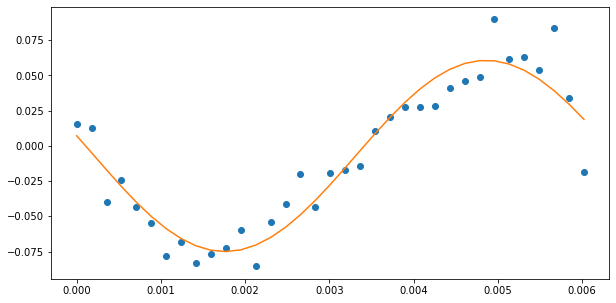

particle is:2
1013.7470694183748
Storage modulus is:254.9780561759067
Loss modulus is:83.56233569849132
R^2: 0.9057639583787405
[ 0.07502598  2.82489929 -0.00475785]


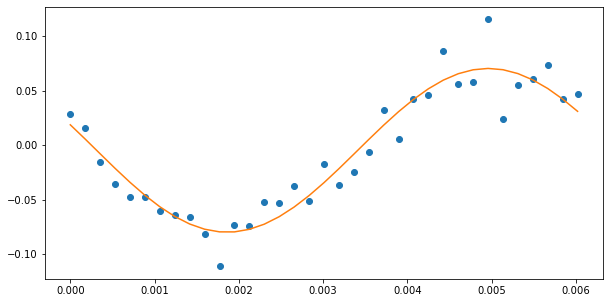

particle is:3
1013.7470694183748
Storage modulus is:245.59636605302387
Loss modulus is:122.59835764181472
R^2: 0.8929035876364619
[ 7.33384358e-02  2.67859616e+00 -1.67603124e-03]


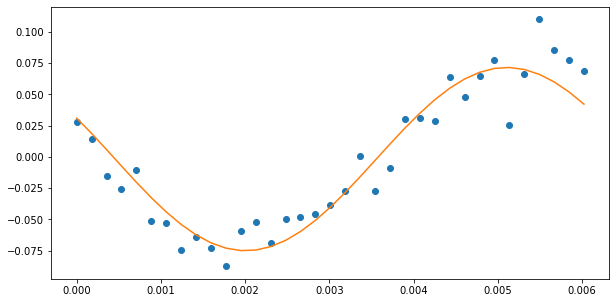

particle is:5
1478.381142901797
Storage modulus is:140.65472449077365
Loss modulus is:310.4751645516108
R^2: 0.8752305390955682
[ 0.05906147  1.99616757 -0.07043088]


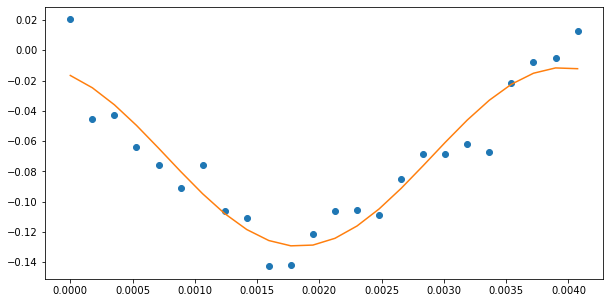

particle is:7
1013.7470694183748
Storage modulus is:269.3078911022513
Loss modulus is:89.35852465688684
R^2: 0.8971608894017774
[ 0.07094762  2.82121549 -0.01123535]


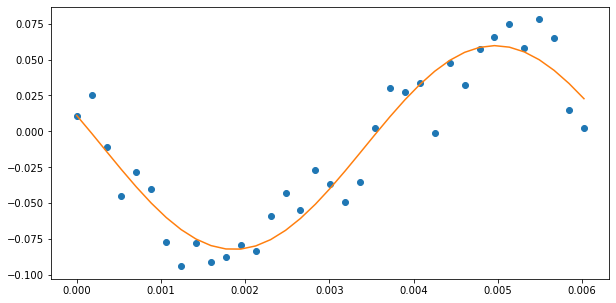

particle is:9
1043.563159695386
Storage modulus is:221.49617326977423
Loss modulus is:120.3231771858302
R^2: 0.9016259102460095
[ 0.07986377  2.64396265 -0.00589343]


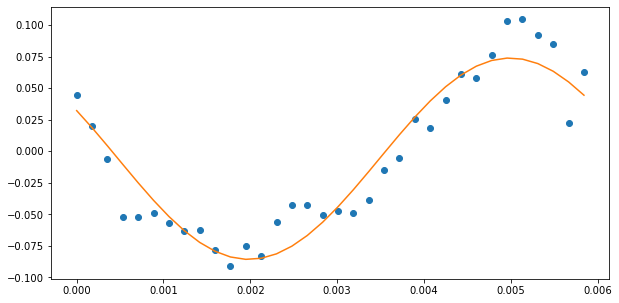

particle is:12
1013.7470694183748
Storage modulus is:196.45659853875532
Loss modulus is:111.17867692401269
R^2: 0.9253635932985785
[ 0.08918054  2.62660917 -0.02648497]


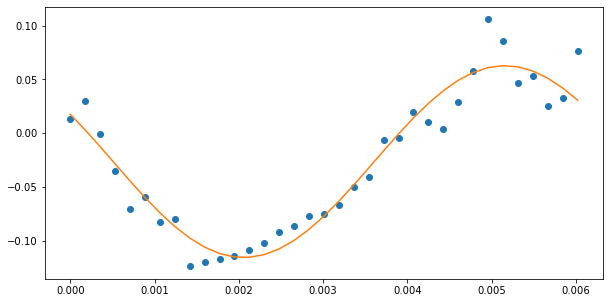

particle is:10
1774.0573714821562
Storage modulus is:2570.8557868279463
Loss modulus is:1.1416893150108837e-12
R^2: 0.03620351528936838
[ 7.83050186e-03  3.14159265e+00 -1.23263965e-03]


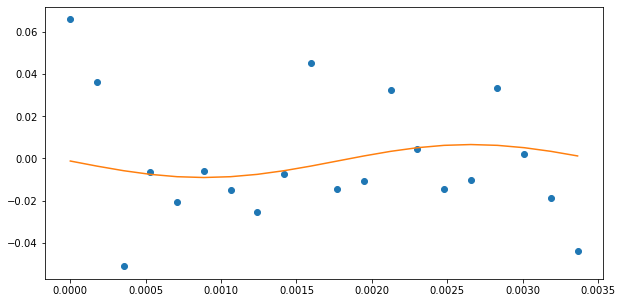

particle is:11
3225.558857240284
Storage modulus is:-448.1313828106045
Loss modulus is:185.00977066333064
R^2: 0.7405643192477962
[ 0.04152282  0.39153222 -0.02853794]


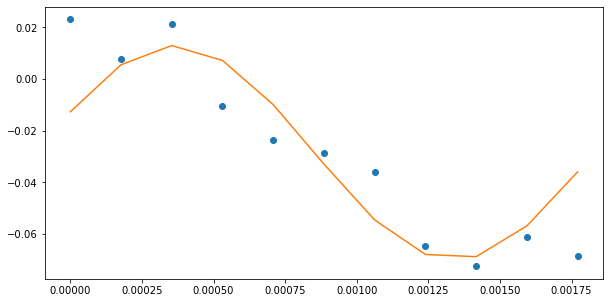

particle is:14
1043.563159695386
Storage modulus is:263.75472578724776
Loss modulus is:95.24396846407465
R^2: 0.8982387371557975
[0.07178789 2.79505645 0.00462431]


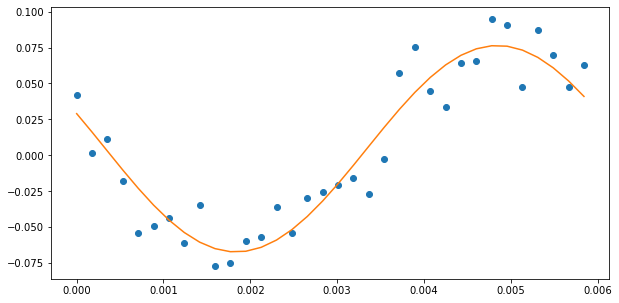

particle is:15
1013.7470694183748
Storage modulus is:255.33590999282012
Loss modulus is:65.97471787183375
R^2: 0.9205223671141967
[ 0.07633463  2.88873885 -0.01585452]


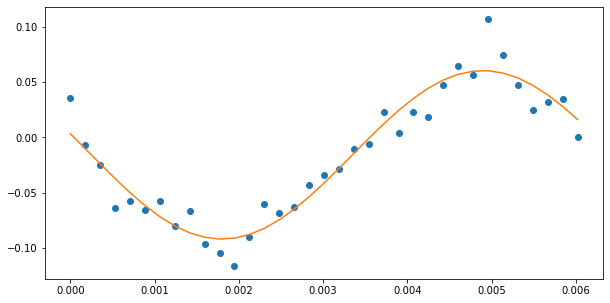

particle is:16
1043.563159695386
Storage modulus is:253.97050443105383
Loss modulus is:117.00516552566725
R^2: 0.9112616259987758
[0.07199267 2.70987322 0.00294265]


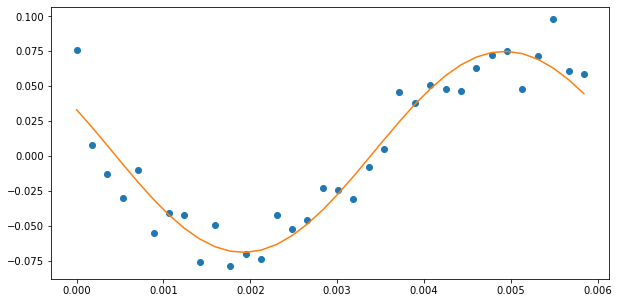

particle is:17
2365.409828642875
Storage modulus is:-354.7443792456387
Loss modulus is:593.2054758558187
R^2: 0.6012856767165227
[ 0.02912549  1.03183939 -0.03714352]


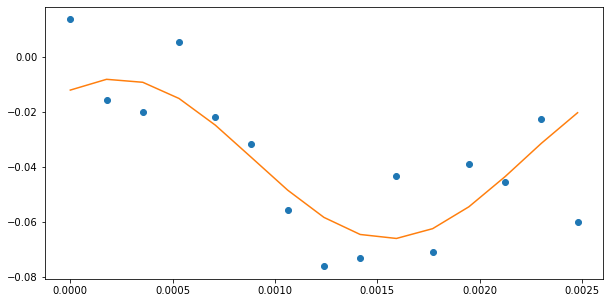

particle is:22
1013.7470694183748
Storage modulus is:256.66294272894214
Loss modulus is:108.95156563595367
R^2: 0.8920905194897221
[7.21983745e-02 2.74015171e+00 2.45967545e-03]


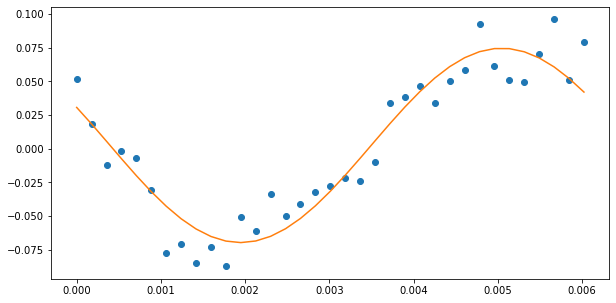

particle is:23
1013.7470694183748
Storage modulus is:348.94059288478644
Loss modulus is:109.07858494379819
R^2: 0.4826693711033203
[ 0.05506433  2.83861732 -0.06423912]


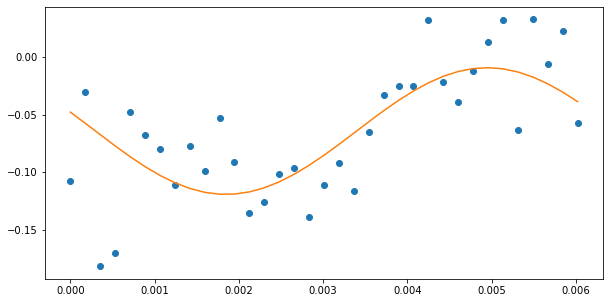

particle is:24
1013.7470694183748
Storage modulus is:371.714987707116
Loss modulus is:72.48529978173852
R^2: 0.8471791687757916
[0.0531561  2.9490071  0.03710239]


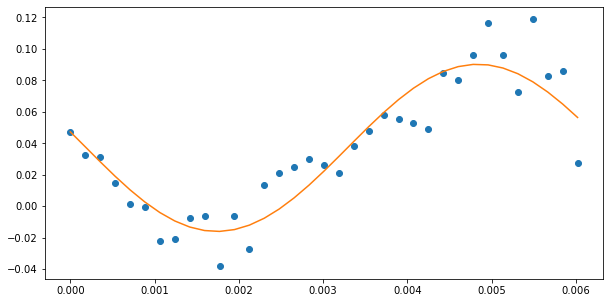

particle is:25
1013.7470694183748
Storage modulus is:272.75902258204866
Loss modulus is:71.75108399966905
R^2: 0.9064974035203465
[0.07137711 2.8843636  0.01212589]


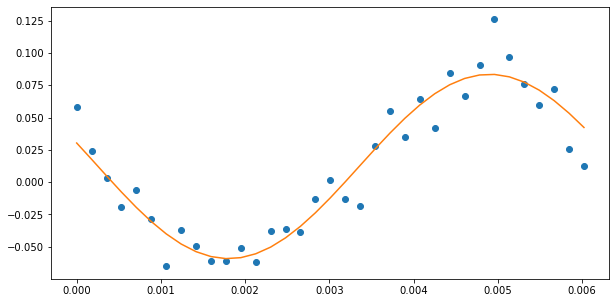

particle is:26
1013.7470694183748
Storage modulus is:282.3003735179664
Loss modulus is:137.13515460474136
R^2: 0.9319832799703883
[ 6.41431355e-02  2.68938769e+00 -2.17881452e-03]


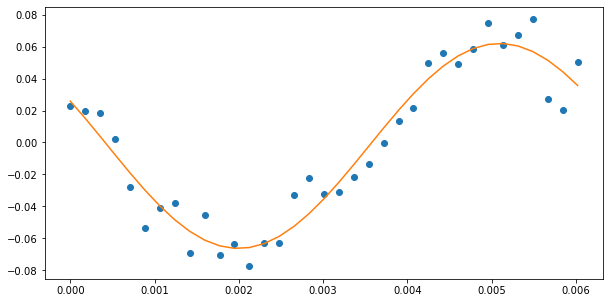

particle is:27
1013.7470694183748
Storage modulus is:337.5733476788391
Loss modulus is:99.4746485676121
R^2: 0.8472051464460846
[ 0.05720284  2.85502771 -0.0115119 ]


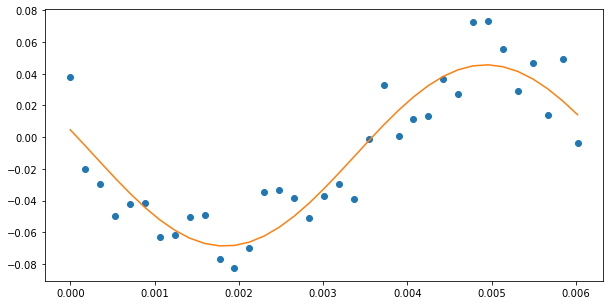

particle is:28
1013.7470694183748
Storage modulus is:292.05032194008305
Loss modulus is:107.59386273370045
R^2: 0.7956118051260713
[0.06468045 2.78861319 0.07031944]


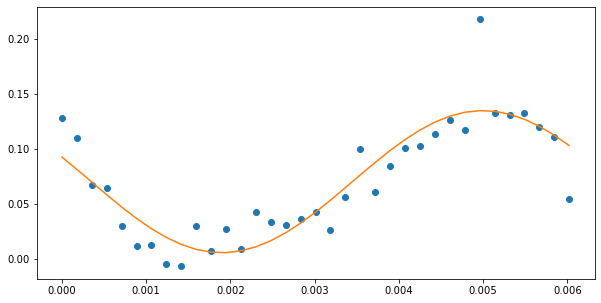

particle is:29
1043.563159695386
Storage modulus is:304.501348375948
Loss modulus is:92.06985985306252
R^2: 0.8950218261091051
[6.32821896e-02 2.84796963e+00 2.26090425e-03]


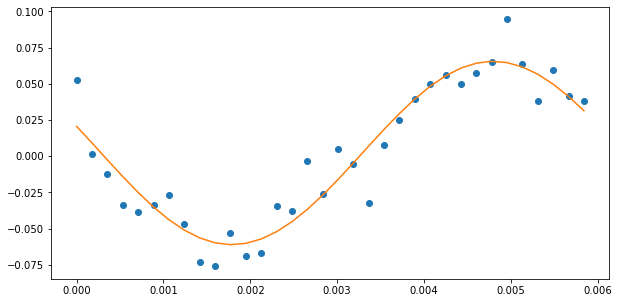

particle is:30
1043.563159695386
Storage modulus is:296.72248550989104
Loss modulus is:96.78815340840856
R^2: 0.8585045656044653
[0.06450014 2.82628407 0.00821542]


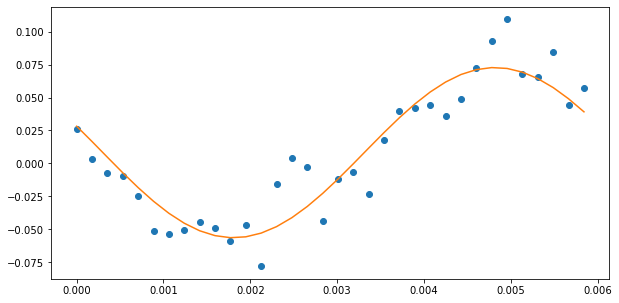

particle is:31
1013.7470694183748
Storage modulus is:121.4547665970237
Loss modulus is:324.8391373583143
R^2: 0.8298479799080095
[ 0.05804777  1.92859528 -0.03470642]


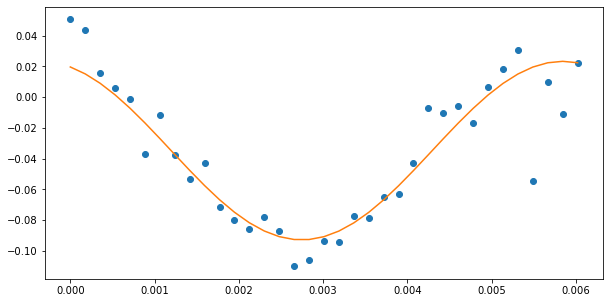

particle is:32
1013.7470694183748
Storage modulus is:319.7378764223931
Loss modulus is:42.13900128847281
R^2: 0.9038697369227211
[ 6.24214610e-02  3.01055551e+00 -2.02723736e-03]


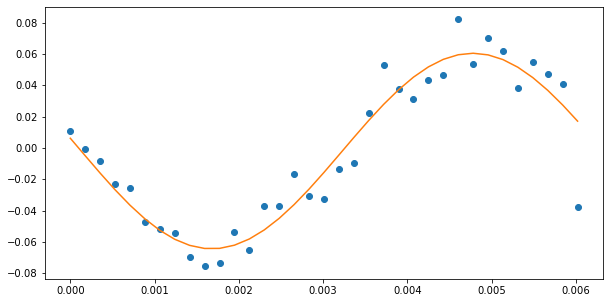

particle is:40
1013.7470694183748
Storage modulus is:254.88951106230232
Loss modulus is:86.61629359931119
R^2: 0.9117245839817492
[0.07477993 2.81401642 0.00904855]


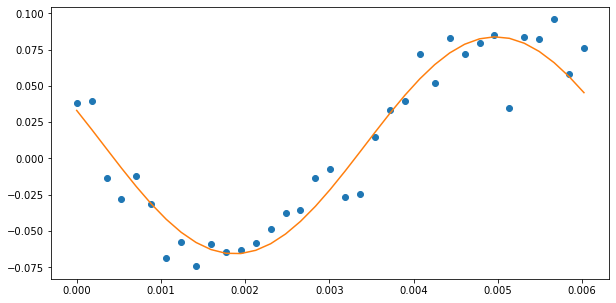

particle is:41
1144.5531428917136
Storage modulus is:342.88929957295426
Loss modulus is:56.715688200328074
R^2: 0.8695249387004333
[0.05792317 2.97767156 0.01100056]


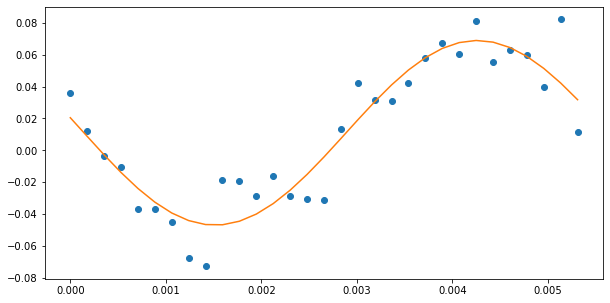

particle is:42
1013.7470694183748
Storage modulus is:284.32726778130353
Loss modulus is:123.14757652634117
R^2: 0.902339289736768
[ 0.06497034  2.73286519 -0.00511094]


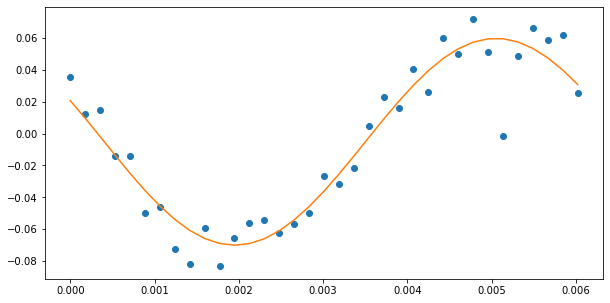

particle is:43
1013.7470694183748
Storage modulus is:292.1545567638569
Loss modulus is:77.12494945688516
R^2: 0.8916161483220562
[0.06662326 2.88349387 0.00436817]


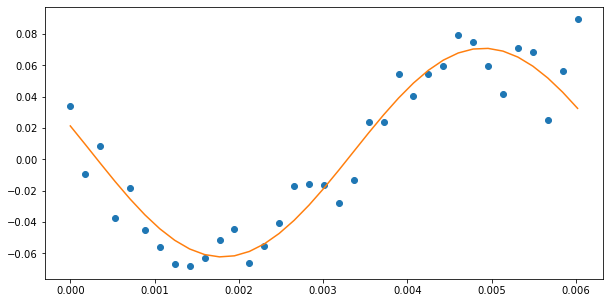

particle is:44
1013.7470694183748
Storage modulus is:296.77090293834766
Loss modulus is:93.86731103673127
R^2: 0.913029974855284
[ 0.06467571  2.83525368 -0.00954579]


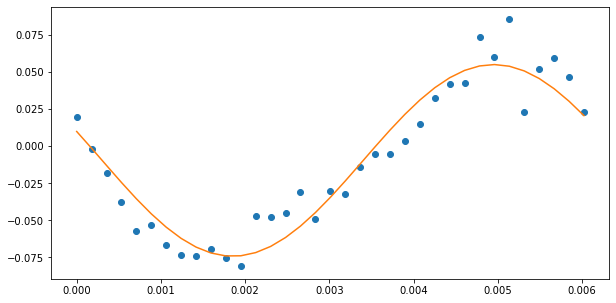

particle is:45
985.5874286011978
Storage modulus is:156.84630394998737
Loss modulus is:192.60256543064298
R^2: 0.6609170585853359
[ 0.08104701  2.25422749 -0.03675461]


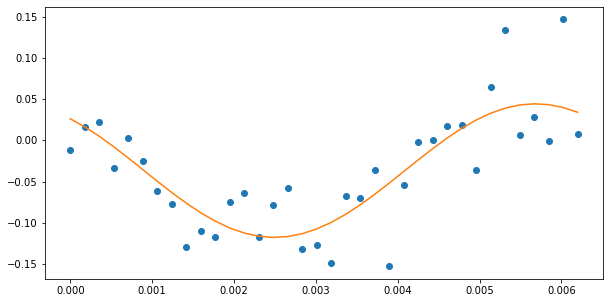

particle is:46
1013.7470694183748
Storage modulus is:297.65936655544857
Loss modulus is:98.80660309662223
R^2: 0.8922058724998277
[0.06418737 2.82109192 0.00895917]


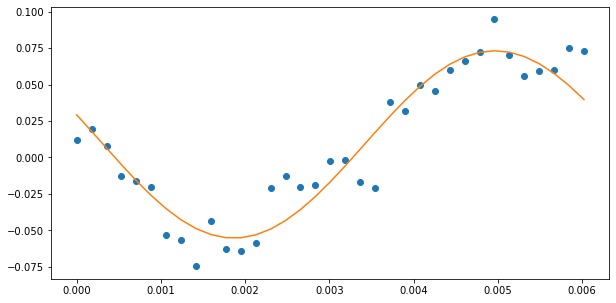

particle is:47
1043.563159695386
Storage modulus is:193.452821668497
Loss modulus is:94.49703380181512
R^2: 0.9047484308008862
[0.09350292 2.68720678 0.00362036]


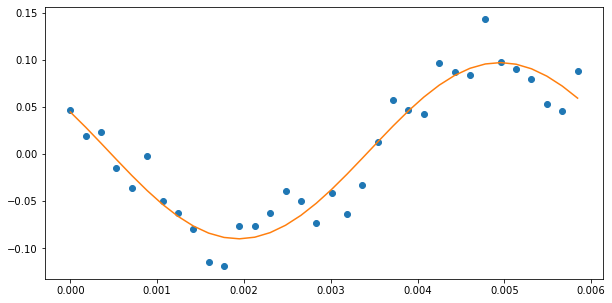

particle is:49
3225.558857240284
Storage modulus is:-284.8468408411814
Loss modulus is:112.03516496283022
R^2: 0.720551677436041
[ 0.06576906  0.37473211 -0.05999305]


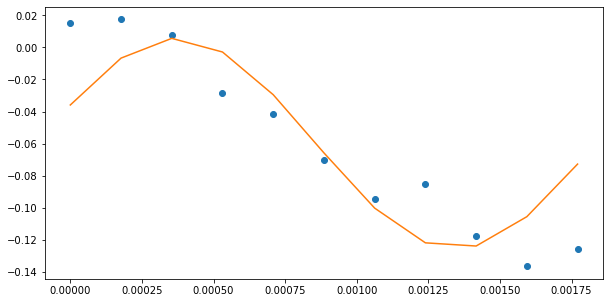

particle is:50
1013.7470694183748
Storage modulus is:255.65231466719706
Loss modulus is:26.245742244066555
R^2: 0.7197758968038774
[ 7.83323121e-02  3.03928920e+00 -1.81021668e-03]


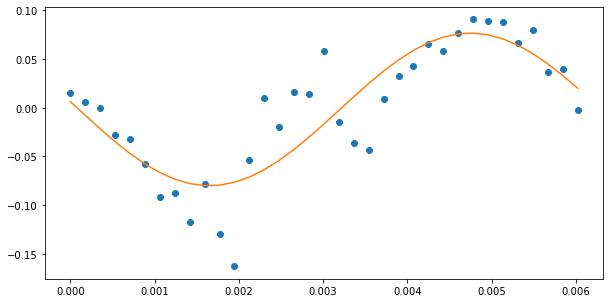

particle is:53
1043.563159695386
Storage modulus is:332.30472970842857
Loss modulus is:72.3997201121946
R^2: 0.8817187818508382
[ 0.05919165  2.92707352 -0.0161411 ]


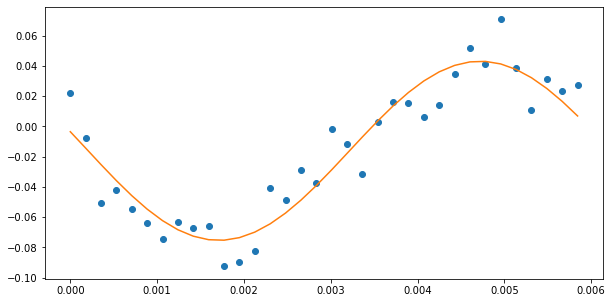

particle is:56
1013.7470694183748
Storage modulus is:246.9028395316733
Loss modulus is:76.54258211592193
R^2: 0.9082643663444345
[ 0.077878    2.840977   -0.01946852]


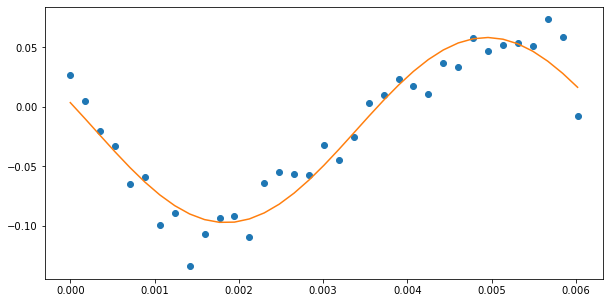

particle is:58
1013.7470694183748
Storage modulus is:348.70094187798156
Loss modulus is:90.28554686045723
R^2: 0.5461701908626868
[ 0.05588869  2.88823675 -0.04924802]


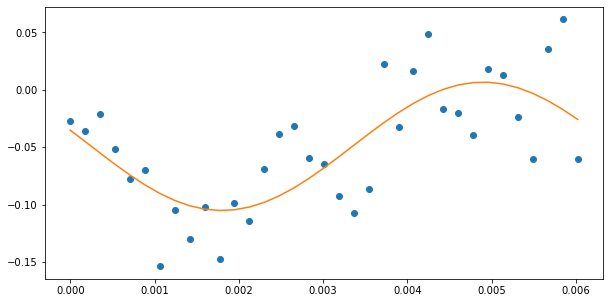

particle is:59
1013.7470694183748
Storage modulus is:292.44742343394495
Loss modulus is:93.69738212855891
R^2: 0.911106392553894
[0.06555422 2.8315355  0.00629993]


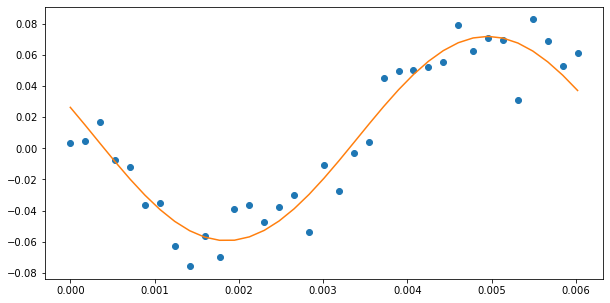

particle is:60
1013.7470694183748
Storage modulus is:289.6079598428989
Loss modulus is:82.58024221908204
R^2: 0.8494549550497082
[0.06684704 2.86381946 0.00405393]


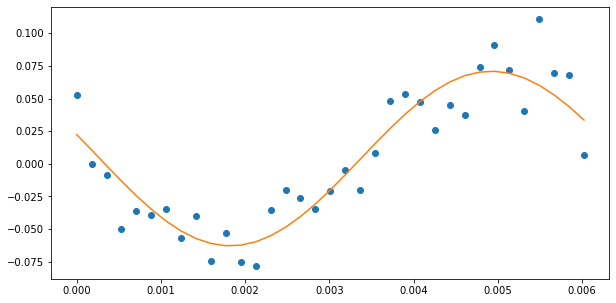

particle is:63
1013.7470694183748
Storage modulus is:324.12448854501366
Loss modulus is:134.03365768215102
R^2: 0.8948717032950105
[5.73953146e-02 2.74948123e+00 4.99536474e-04]


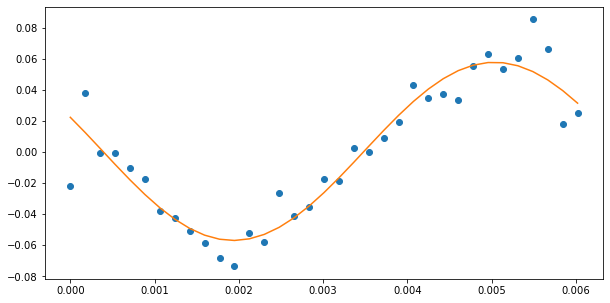

particle is:64
2956.762285803594
Storage modulus is:-529.5204823511277
Loss modulus is:789.5329136810681
R^2: 0.41286175256151336
[ 0.02117591  0.98002342 -0.0286001 ]


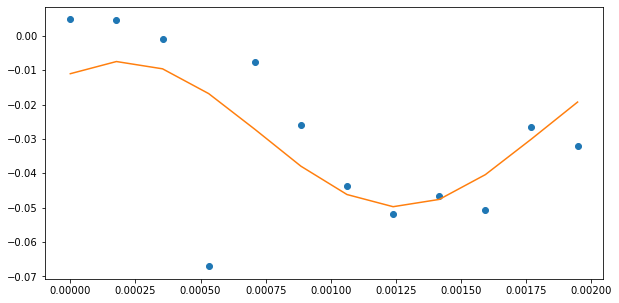

particle is:66
1013.7470694183748
Storage modulus is:284.49092445627065
Loss modulus is:112.9804515100556
R^2: 0.864192439712617
[0.06576552 2.76356113 0.01272567]


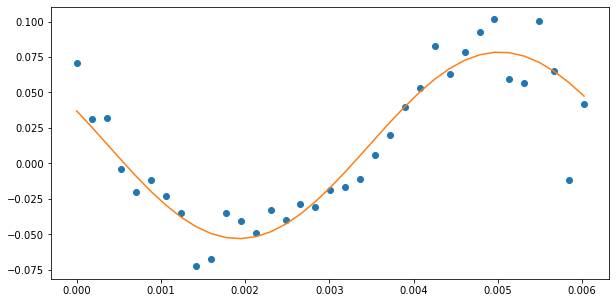

particle is:68
1013.7470694183748
Storage modulus is:252.94684759429518
Loss modulus is:106.95121705898659
R^2: 0.8996874244937865
[ 0.07330306  2.74156916 -0.00473912]


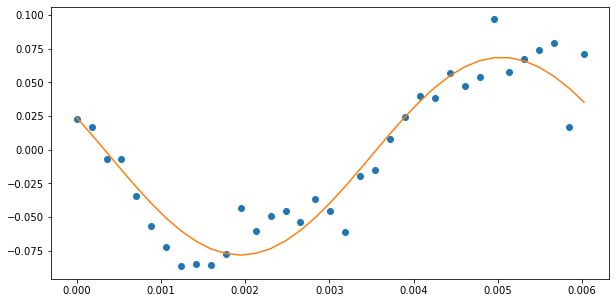

particle is:69
1013.7470694183748
Storage modulus is:210.19892565018375
Loss modulus is:97.25718861290223
R^2: 0.9183851199407468
[ 0.08691858  2.70823501 -0.01258819]


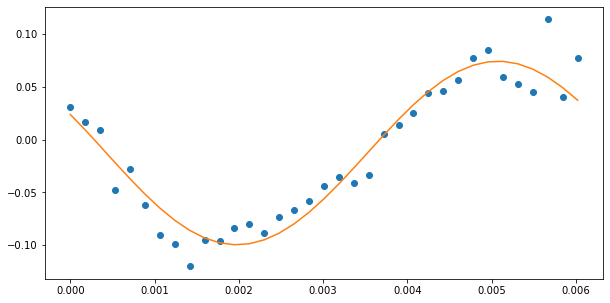

particle is:70
1013.7470694183748
Storage modulus is:291.77557469262683
Loss modulus is:89.23666101707813
R^2: 0.9029553032873912
[ 0.06597834  2.84478665 -0.00544587]


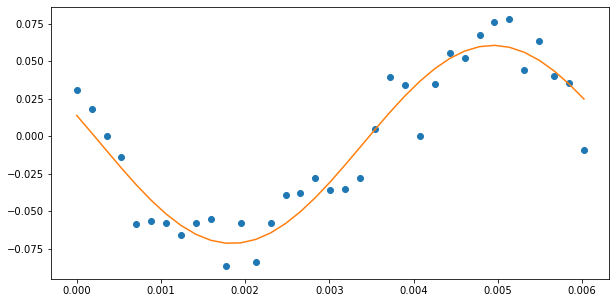

particle is:71
1013.7470694183748
Storage modulus is:-1197.7834692181577
Loss modulus is:1.4668616916496291e-13
R^2: 0.05056306201909122
[ 1.68069535e-02  1.75683360e-18 -2.19023023e-04]


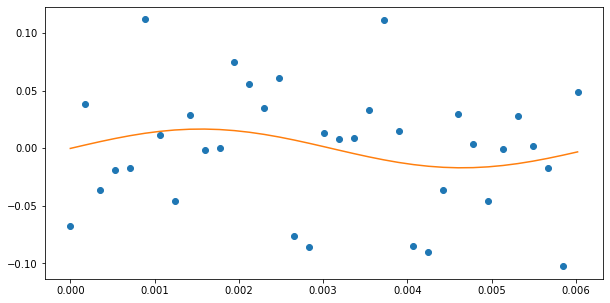

particle is:72
1013.7470694183748
Storage modulus is:251.46256187774273
Loss modulus is:98.56648143022592
R^2: 0.9108036264611571
[0.07453467 2.76802538 0.04775413]


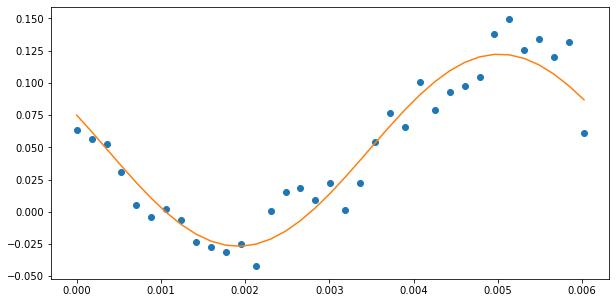

particle is:73
1013.7470694183748
Storage modulus is:300.1342916387471
Loss modulus is:105.34153718997173
R^2: 0.8832674845995948
[ 6.32885995e-02  2.80404385e+00 -2.25539241e-03]


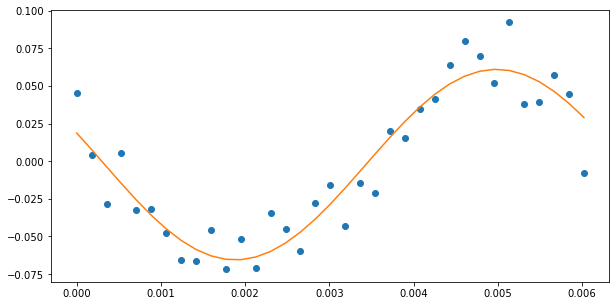

particle is:74
1013.7470694183748
Storage modulus is:260.23245781073047
Loss modulus is:131.42828671004906
R^2: 0.8891768656653058
[0.06905138 2.67391969 0.00282621]


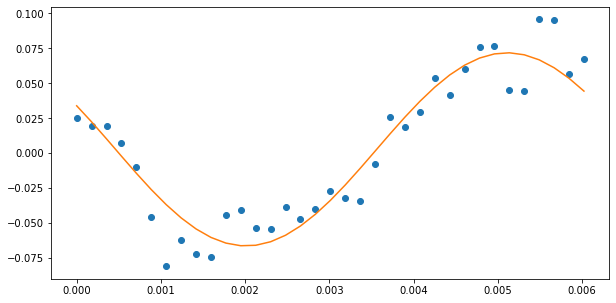

particle is:75
1013.7470694183748
Storage modulus is:228.9182173817819
Loss modulus is:72.48211092244269
R^2: 0.9316944307956129
[ 0.08383792  2.83495071 -0.01229689]


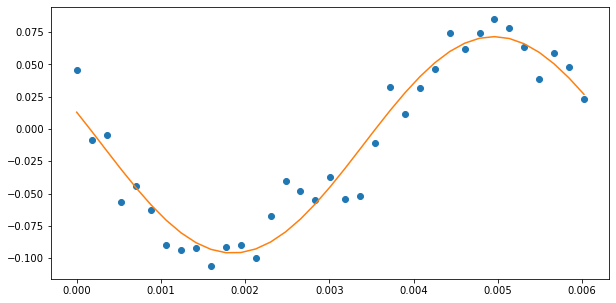

particle is:76
1013.7470694183748
Storage modulus is:300.60460711529686
Loss modulus is:113.60455317329767
R^2: 0.850054224309581
[0.06264437 2.78026427 0.00292254]


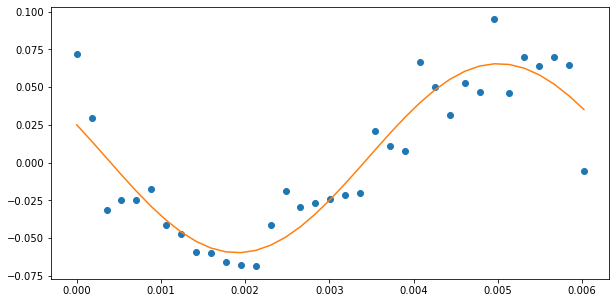

particle is:77
1013.7470694183748
Storage modulus is:193.00491894437982
Loss modulus is:116.65371578276755
R^2: 0.9372006781409855
[ 0.08926546  2.59793828 -0.04283064]


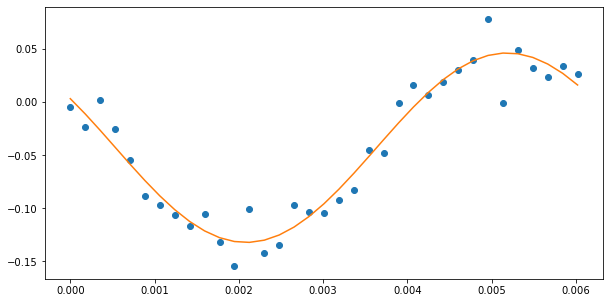

particle is:78
1013.7470694183748
Storage modulus is:187.6248527063768
Loss modulus is:90.39371550610211
R^2: 0.9448077254300132
[ 0.09666117  2.6926278  -0.00582536]


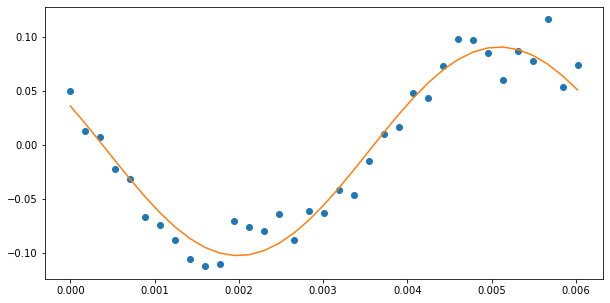

particle is:80
1013.7470694183748
Storage modulus is:211.4631033007925
Loss modulus is:106.21249997231169
R^2: 0.8525332822359553
[0.0850711  2.67612719 0.01423614]


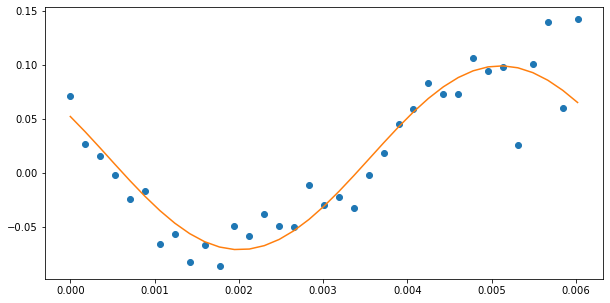

particle is:81
1013.7470694183748
Storage modulus is:352.391108037946
Loss modulus is:131.10584205188306
R^2: 0.9211361167382943
[0.05354161 2.78541395 0.00412036]


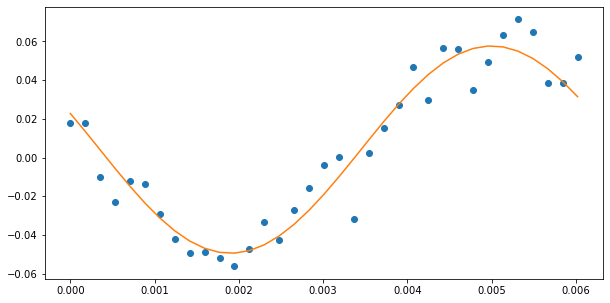

particle is:82
1043.563159695386
Storage modulus is:242.26500720749894
Loss modulus is:90.97964311571934
R^2: 0.9060026529209396
[ 0.07779082  2.78235066 -0.02356512]


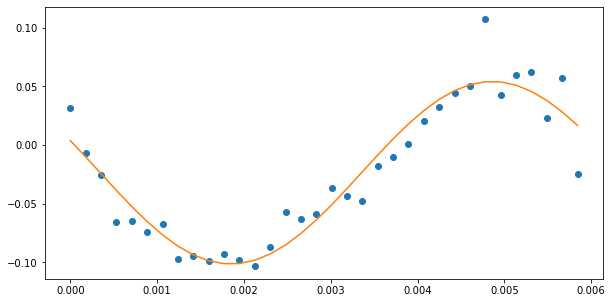

particle is:83
1542.6585838975273
Storage modulus is:165.34410634830024
Loss modulus is:628.4218471336774
R^2: 0.27716425415355106
[ 0.03097998  1.8280753  -0.04225091]


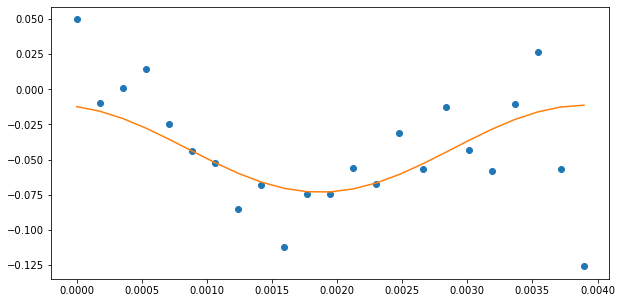

particle is:93
1013.7470694183748
Storage modulus is:231.3553064008809
Loss modulus is:85.75117500094535
R^2: 0.9334348690919435
[ 0.08158967  2.78664367 -0.02344701]


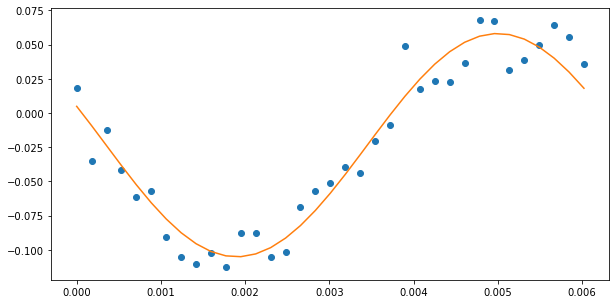

particle is:94
1013.7470694183748
Storage modulus is:241.55782789911774
Loss modulus is:124.73904663387867
R^2: 0.9224665884117174
[ 0.0740484   2.66491592 -0.00686845]


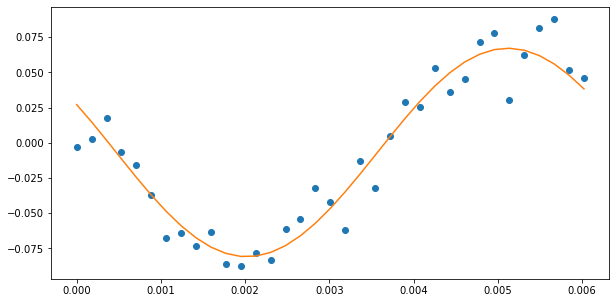

particle is:95
1013.7470694183748
Storage modulus is:287.6392597993243
Loss modulus is:86.58299900881882
R^2: 0.8744304528017184
[0.06701696 2.84920726 0.00980866]


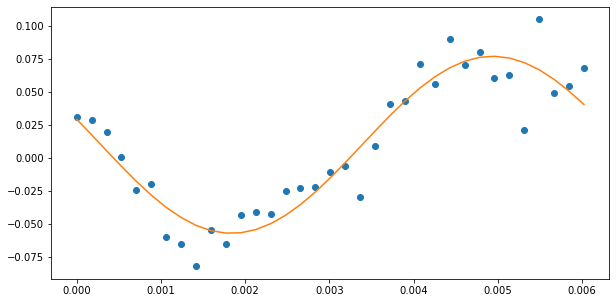

particle is:96
1043.563159695386
Storage modulus is:306.46072798623766
Loss modulus is:115.99834054929553
R^2: 0.8464181894903245
[0.06143533 2.77974859 0.006104  ]


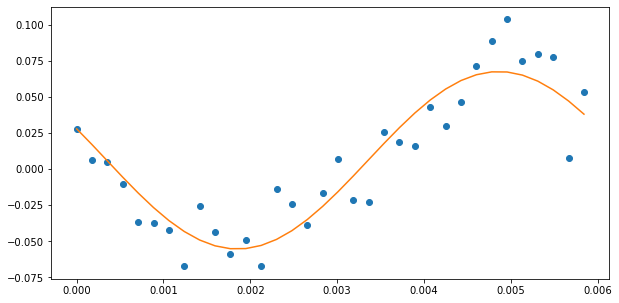

particle is:97
1013.7470694183748
Storage modulus is:275.4981752776798
Loss modulus is:66.0368367366869
R^2: 0.9312393533367452
[0.07105873 2.90633161 0.00592057]


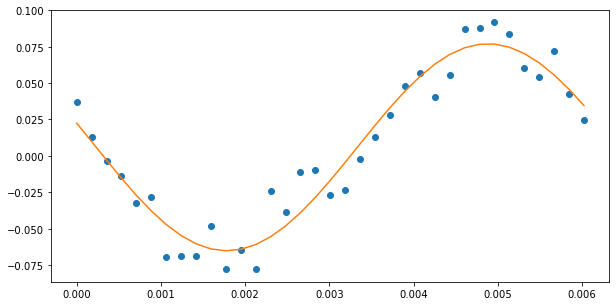

particle is:98
1013.7470694183748
Storage modulus is:242.0487678943637
Loss modulus is:97.53662764604634
R^2: 0.9173914965212161
[0.07714194 2.75853483 0.00756412]


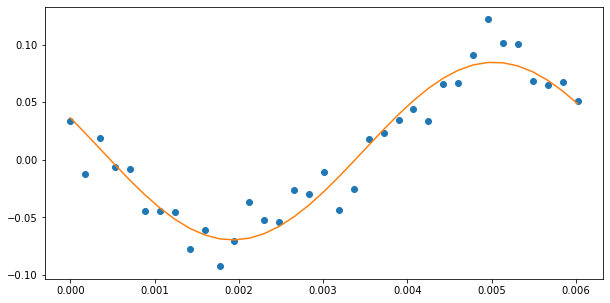

particle is:99
1013.7470694183748
Storage modulus is:309.7368654442327
Loss modulus is:138.9686330014045
R^2: 0.810419047718261
[0.05929913 2.71984801 0.0077436 ]


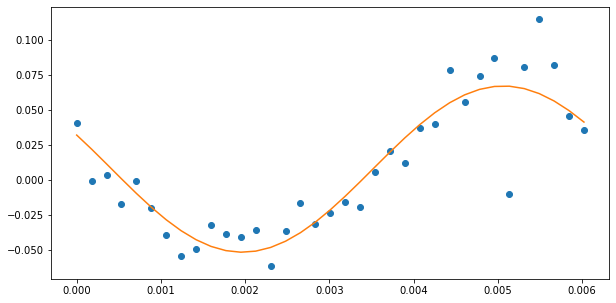

particle is:100
1013.7470694183748
Storage modulus is:383.3001399515328
Loss modulus is:258.07733529217825
R^2: 0.4641037383498473
[0.04356574 2.54900937 0.02995434]


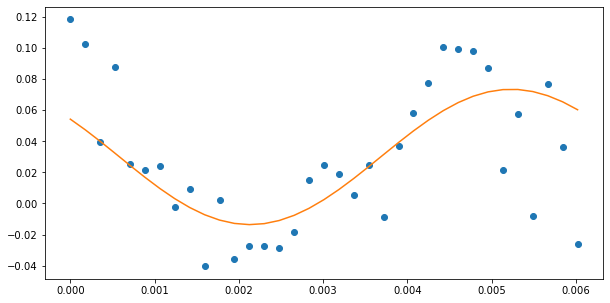

particle is:101
1013.7470694183748
Storage modulus is:372.8654356480603
Loss modulus is:77.42582843833073
R^2: 0.910121683298065
[ 5.28625712e-02  2.93685144e+00 -6.40503454e-04]


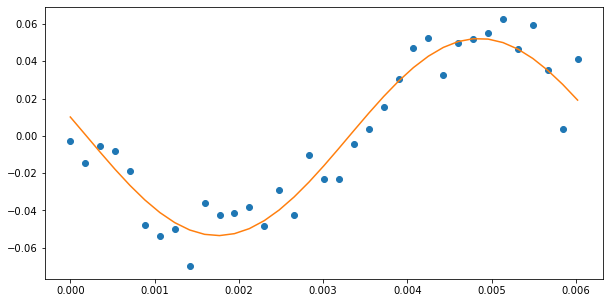

particle is:102
1043.563159695386
Storage modulus is:227.41755238272015
Loss modulus is:184.42264073660718
R^2: 0.8715324039496473
[0.06875428 2.46021476 0.03203428]


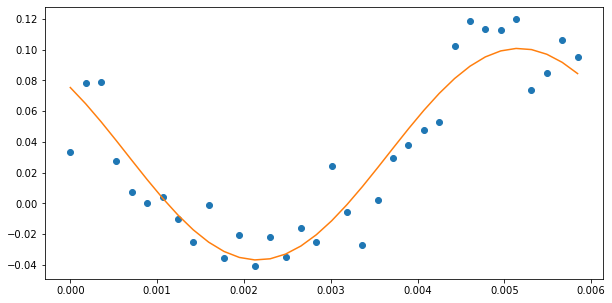

particle is:103
1013.7470694183748
Storage modulus is:311.0321388632043
Loss modulus is:111.13862786967707
R^2: 0.8857358523501653
[0.06094938 2.79840984 0.00559377]


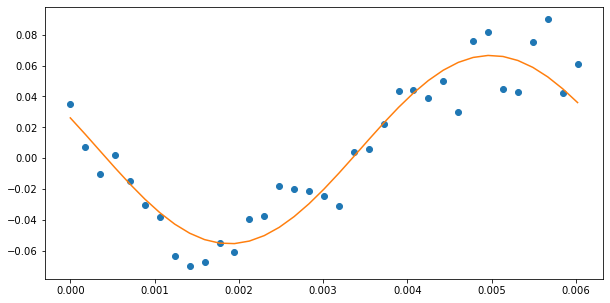

particle is:104
1013.7470694183748
Storage modulus is:265.37473747526684
Loss modulus is:97.96441603458673
R^2: 0.8977613974329207
[0.07116491 2.78795617 0.01453663]


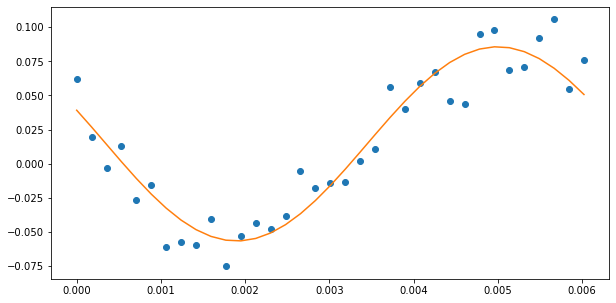

particle is:106
1013.7470694183748
Storage modulus is:273.0897009286017
Loss modulus is:93.55433495130875
R^2: 0.9412902068674794
[0.06973737 2.81154572 0.00661713]


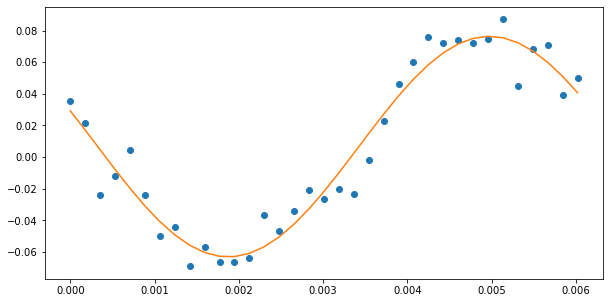

particle is:109
1013.7470694183748
Storage modulus is:314.6791639763419
Loss modulus is:96.98378580815206
R^2: 0.8635716400097713
[0.06113571 2.84263097 0.00687353]


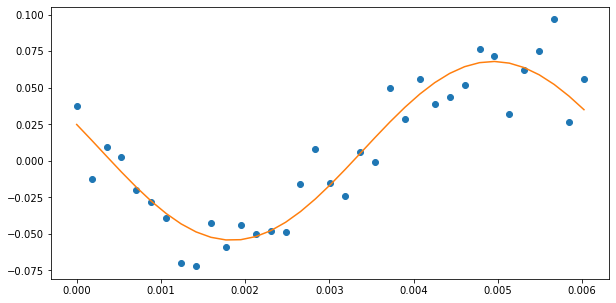

particle is:108
788.4699428809583
Storage modulus is:232.05480461492667
Loss modulus is:144.1715014402982
R^2: -1.8717736798355489
[0.07368795 2.58567134 0.1       ]


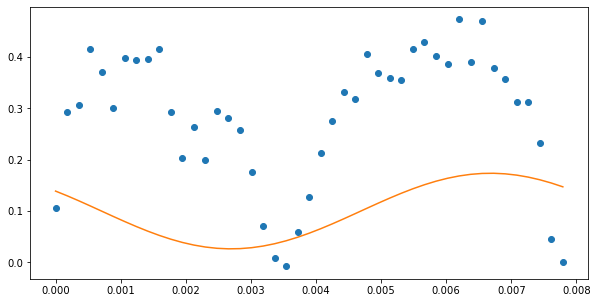

particle is:110
2534.367673545937
Storage modulus is:-449.3685996797943
Loss modulus is:6.694757215843442
R^2: -0.9261304823751246
[0.04479364 0.01489704 0.1       ]


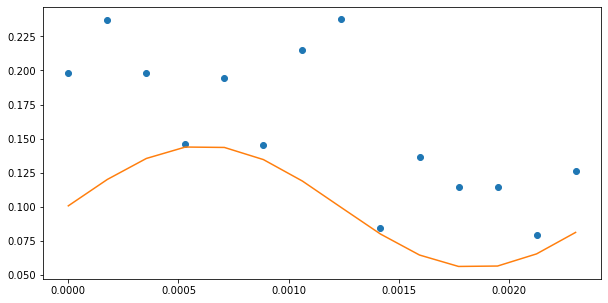

In [68]:
data2=utils.analyze_wavelength_modulus(wavelength2,gamma2list_w2,real_stress,framerate,imgname)

# Concatenate

In [69]:
final_output = pd.concat([data1, data2], ignore_index=True)

In [70]:
final_output.to_csv('/Volumes/T7_Shield/Rheofluidics/Rheofluidics_code/20231013/results/120727_new.csv', index=False)